In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving 4.18states.csv to 4.18states.csv
Saving abridged_couties.csv to abridged_couties.csv
Saving README.md to README.md
Saving time_series_covid19_confirmed_US.csv to time_series_covid19_confirmed_US.csv
Saving time_series_covid19_deaths_US.csv to time_series_covid19_deaths_US.csv


# Part I: Exploring the Datasets
## Section A: Data Cleaning

First, we will get the CSV datasets provided and convert them to Pandas Dataframes.

In [0]:
states = pd.read_csv('4.18states.csv')
covid19confirmed = pd.read_csv('time_series_covid19_confirmed_US.csv')
covid19deaths = pd.read_csv('time_series_covid19_deaths_US.csv')

Our first method of analysis was to form predictive models at the state-level. To accomplish this, we used counties dataset and grouped columns according to state. We identified three primary ways to group the columns: mean, sum, and a weighted sum and placed each feature column in its respective group. We go into more depth as to how we derived these three categories in our paper.

In [0]:
abridged_counties = pd.read_csv('abridged_couties.csv')
mean = ['StateName', 'Rural-UrbanContinuumCode2013','FracMale2017','PopulationDensityperSqMile2010','MedianAge2010','3-YrDiabetes2015-17','DiabetesPercentage','StrokeMortality','HeartDiseaseMortality','RespMortalityRate2014','stay at home','>50 gatherings','>500 gatherings','public schools','restaurant dine-in','entertainment/gym','federal guidelines','foreign travel ban']
sumlist = ['StateName', 'PopulationEstimate2018','PopTotalMale2017','PopTotalFemale2017','PopulationEstimate65+2017','#EligibleforMedicare2018','MedicareEnrollment,AgedTot2017','#FTEHospitalTotal2017',"TotalM.D.'s,TotNon-FedandFed2017","#Hospitals",'#ICU_beds','PopMale<52010','PopFmle<52010','PopMale5-92010','PopFmle5-92010','PopMale10-142010','PopFmle10-142010','PopMale15-192010','PopFmle15-192010','PopMale20-242010','PopFmle20-242010','PopMale25-292010','PopFmle25-292010','PopMale30-342010','PopFmle30-342010','PopMale35-442010','PopFmle35-442010','PopMale45-542010','PopFmle45-542010','PopMale55-592010','PopFmle55-592010','PopMale60-642010','PopFmle60-642010','PopMale65-742010','PopFmle65-742010','PopMale75-842010','PopFmle75-842010','PopMale>842010','PopFmle>842010']
need_to_weight = ['StateName', 'PopulationEstimate2018', 'Smokers_Percentage','dem_to_rep_ratio','3-YrMortalityAge<1Year2015-17','3-YrMortalityAge1-4Years2015-17','3-YrMortalityAge5-14Years2015-17','3-YrMortalityAge15-24Years2015-17','3-YrMortalityAge25-34Years2015-17','3-YrMortalityAge35-44Years2015-17','3-YrMortalityAge45-54Years2015-17','3-YrMortalityAge55-64Years2015-17','3-YrMortalityAge65-74Years2015-17','3-YrMortalityAge75-84Years2015-17','3-YrMortalityAge85+Years2015-17','SVIPercentile']
mean_abridged_counties = abridged_counties[mean]
sum_abridged_counties = abridged_counties[sumlist]
weight_abridged_counties = abridged_counties[need_to_weight]
def need_to_weight(data):
  weight_cols = data.columns[2:]
  for col in abd_col:
    weighted_val += data['PopulationEstimate2018']*val
  return weighted_val
abridged_counties.head()

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,...,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,South,East South Central,2.0,55601.0,27007.0,28497.0,0.486578,8392.0,91.8,54571.0,37.0,11439.0,8046.0,16.0,9.9,204.5,56.1,18.081557,81.79,324.0,50.0,0.0,1.0,6.0,0.326656,1866.0,1713.0,2001.0,1990.0,2171.0,...,1594.0,1736.0,3978.0,4265.0,4040.0,4165.0,1524.0,1559.0,1279.0,1498.0,1821.0,2192.0,841.0,1141.0,159.0,392.0,NaN,NaN,NaN,NaN,10.0,20.0,44.0,73.0,112.0,143.0,109.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,South,East South Central,3.0,218022.0,103225.0,109403.0,0.485472,42413.0,114.7,182265.0,41.1,54145.0,41590.0,33.0,8.5,183.2,41.9,17.489033,54.28,2101.0,536.0,0.0,3.0,51.0,0.253255,5614.0,5544.0,5832.0,5767.0,6076.0,...,5317.0,5392.0,11620.0,11933.0,13047.0,13874.0,5943.0,6580.0,5728.0,6284.0,8558.0,9245.0,4379.0,5153.0,1176.0,2057.0,13.0,NaN,NaN,23.0,30.0,52.0,125.0,262.0,434.0,546.0,597.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,South,East South Central,6.0,24881.0,13335.0,11935.0,0.527701,4757.0,31.0,27457.0,39.0,6681.0,4706.0,NaN,15.7,220.4,49.0,21.999985,69.82,181.0,12.0,0.0,1.0,5.0,0.893106,847.0,855.0,826.0,816.0,820.0,...,1162.0,646.0,2115.0,1513.0,2164.0,1854.0,910.0,907.0,859.0,940.0,1067.0,1171.0,498.0,730.0,129.0,314.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,44.0,65.0,72.0,68.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,South,East South Central,1.0,22400.0,12138.0,10530.0,0.535469,3632.0,36.8,22915.0,37.8,5128.0,3389.0,NaN,13.3,225.5,57.2,19.114200,84.49,145.0,16.0,0.0,1.0,0.0,0.278124,712.0,666.0,759.0,646.0,771.0,...,1013.0,633.0,1895.0,1487.0,1883.0,1503.0,734.0,667.0,684.0,650.0,803.0,920.0,370.0,534.0,73.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,37.0,62.0,56.0,45.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,South,East South Central,1.0,57840.0,28607.0,29406.0,0.493114,10351.0,88.9,57322.0,39.0,13175.0,9542.0,NaN,14.9,224.8,52.8,19.208672,87.05,103.0,18.0,1.0,1.0,6.0,0.094317,1805.0,1811.0,1936.0,1944

Here, we apply the grouping methods on all of the feature columns and aggrgate the table accordingly. We replace NaN values with the column mean, and we used the grouping from earlier to group the counties by state and aggregate the columns appropriately. We produce a new dataframe which we shall use for analysis. We name this table "abridged_by_state".

In [0]:
def clean_and_agg(abridged_counties, agg_func):  
  nan_check_counties = abridged_counties.isna()
  nan_cols = {}
  for col in nan_check_counties.columns:
    if (np.count_nonzero(nan_check_counties[col]) > 0):
      if (nan_check_counties[col].dtype == str):
        nan_cols[col] = ''
      else:
        nan_cols[col] = np.mean(abridged_counties[col])
  abridged_counties = abridged_counties.fillna(value=nan_cols)
  return abridged_counties
mean_abridged_counties = clean_and_agg(mean_abridged_counties, np.mean)
mean_abridged_counties = mean_abridged_counties.groupby('StateName').mean()
mean_abridged_counties = mean_abridged_counties.reset_index()
sum_abridged_counties = clean_and_agg(sum_abridged_counties, np.mean)
sum_abridged_counties = sum_abridged_counties.groupby('StateName').sum()
sum_abridged_counties = sum_abridged_counties.reset_index()
weight_abridged_counties = clean_and_agg(weight_abridged_counties, np.mean)
new_weight_abridged_counties = pd.DataFrame({'StateName': abridged_counties['StateName']})
for col in weight_abridged_counties.columns[2:]:
  new_col = []
  for i in range(len(weight_abridged_counties[col].to_numpy())):
    new_col.append(weight_abridged_counties[col].to_numpy()[i]*weight_abridged_counties['PopulationEstimate2018'].to_numpy()[i])
  new_series = pd.Series(new_col)
  new_weight_abridged_counties[col] = new_series
new_weight_abridged_counties = new_weight_abridged_counties.groupby('StateName').mean()
new_weight_abridged_counties = new_weight_abridged_counties.reset_index()
abridged_by_state = pd.concat([mean_abridged_counties, sum_abridged_counties.drop(['StateName'], axis=1), new_weight_abridged_counties.drop(['StateName'], axis=1)], axis=1)
abridged_by_state.head()

,StateName,Rural-UrbanContinuumCode2013,FracMale2017,PopulationDensityperSqMile2010,MedianAge2010,3-YrDiabetes2015-17,DiabetesPercentage,StrokeMortality,HeartDiseaseMortality,RespMortalityRate2014,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,PopulationEstimate65+2017,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#Hospitals,#ICU_beds,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,PopFmle10-142010,PopMale15-192010,PopFmle15-192010,PopMale20-242010,PopFmle20-242010,PopMale25-292010,PopFmle25-292010,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,Smokers_Percentage,dem_to_rep_ratio,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,SVIPercentile
0,AK,7.337811,0.536606,33.660163,37.032131,48.064333,8.894451,38.377161,167.179478,57.447205,737511.857607,737507.733936,737507.549010,737502.941257,737501.250874,737501.355471,737500.0,737495.0,1.045433e+06,5.378221e+05,5.087504e+05,1.305886e+05,2.190189e+05,1.254013e+05,20441.708747,3149.095533,26.373448,189.954155,37618.973953,35410.136744,35833.568372,34237.052093,36133.840000,34200.213953,37845.484651,35095.026047,40087.564651,34681.425116,39323.074419,35977.365581,34283.296744,32247.215814,67629.68093,64053.949767,78519.810233,74877.595349,35358.337674,33134.03907,26847.077209,24956.687442,27910.447442,27949.309767,11934.843721,15257.094884,3347.394419,6534.319070,5.686360e+05,33009.283208,1.103401e+06,6.443485e+05,7.104817e+05,1.138471e+06,1.652185e+06,1.746187e+06,2.959201e+06,5.464446e+06,6.070387e+06,6.340824e+06,7.140724e+06,15381.081466
1,AL,4.641791,0.486846,90.216418,39.356716,41.751095,14.407463,51.450746,243.595522,77.282985,737518.865672,737504.000000,737497.000000,737500.000000,737503.000000,737512.000000,737500.0,737495.0,4.887871e+06,2.359836e+06,2.514911e+06,8.037710e+05,1.080141e+06,7.818360e+05,88369.000000,12954.000000,86.000000,1533.000000,155265.000000,149692.000000,157340.000000,150889.000000,163417.000000,156238.000000,175151.000000,168320.000000,167520.000000,167802.000000,153716.000000,157318.000000,146424.000000,151464.000000,303785.00000,315716.000000,337828.000000,356026.000000,149633.000000,162273.00000,131603.000000,144524.000000,170036.000000,200465.000000,85611.000000,125996.000000,22859.000000,52825.000000,1.371885e+06,49111.821414,2.840754e+06,1.382547e+06,1.539827e+06,3.108637e+06,4.895118e+06,6.200122e+06,1.222209e+07,2.562700e+07,3.322148e+07,3.893587e+07,4.407658e+07,44905.444819
2,AR,5.640000,0.494874,54.357333,40.316000,44.349520,13.432000,47.681333,235.172000,72.727067,737512.481146,737510.000000,737510.000000,737501.000000,737503.000000,737503.000000,737500.0,737495.0,3.013825e+06,1.476064e+06,1.528215e+06,4.991440e+05,6.703520e+05,4.809900e+05,58025.000000,7753.000000,74.000000,732.000000,100950.000000,96739.000000,100871.000000,96006.000000,100896.000000,96663.000000,104178.000000,99627.000000,100801.000000,98849.000000,96155.000000,95998.000000,92277.000000,91462.000000,182698.00000,183510.000000,200528.000000,206738.000000,88935.000000,95025.00000,80356.000000,86675.000000,110138.000000,124464.000000,56320.000000,77657.000000,16534.000000,34868.000000,7.840902e+05,25846.686202,1.250992e+06,7.925587e+05,8.739035e+05,1.335316e+06,1.684733e+06,2.193823e+06,3.539317e+06,6.972694e

We load the dataset with death counts and select the column with the latest death figures. We also rename state columns to facilitate merging with the features dataframe. We name this dataframe "deaths".

In [0]:
deaths_group = covid19deaths.groupby('Province_State').sum().reset_index()
deaths = pd.DataFrame()
deaths['State'] = deaths_group['Province_State']
deaths['Number of deaths'] = deaths_group['4/18/20']
deaths = deaths.replace({'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut':'CT','Delaware':'DE','District of Columbia':'DC','Florida':'FL','Georgia':'GA','Guam':'GU','Hawaii':'HI','Idaho':'ID','Illinois':'IL','Indiana':'IN','Iowa':'IA','Kansas':'KS','Kentucky':'KY','Louisiana':'LA','Maine':'ME','Maryland':'MD','Massachusetts':'MA','Michigan':'MI','Minnesota':'MN','Mississippi':'MS','Missouri':'MO','Montana':'MT','Nebraska':'NE','Nevada':'NV','New Hampshire':'NH','New Jersey':'NJ','New Mexico':'NM','New York':'NY','North Carolina':'NC','North Dakota':'ND','Ohio':'OH','Oklahoma':'OK','Oregon':'OR','Pennsylvania':'PA','Puerto Rico':'PR','Rhode Island':'RI','South Carolina':'SC','South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Virginia':'VA','Virgin Islands':'VI','Vermont':'VT','Washington':'WA','Wisconsin':'WI','West Virginia':'WV','Wyoming':'WY'})
deaths.head()

,State,Number of deaths
0,AL,153
1,AK,9
2,AS,0
3,AZ,180
4,AR,38


We load the dataset with confirmed case counts and select the column with the latest case figures. We also rename the "State" column, our primary key, to facilitate merging with the features dataframe. We name this table "cases".

In [0]:
confirmed_group = covid19confirmed.groupby('Province_State').sum().reset_index()
cases = pd.DataFrame()
cases['State'] = confirmed_group['Province_State']
cases['Number of cases'] = confirmed_group['4/18/20']
cases = cases.replace({'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut':'CT','Delaware':'DE','District of Columbia':'DC','Florida':'FL','Georgia':'GA','Guam':'GU','Hawaii':'HI','Idaho':'ID','Illinois':'IL','Indiana':'IN','Iowa':'IA','Kansas':'KS','Kentucky':'KY','Louisiana':'LA','Maine':'ME','Maryland':'MD','Massachusetts':'MA','Michigan':'MI','Minnesota':'MN','Mississippi':'MS','Missouri':'MO','Montana':'MT','Nebraska':'NE','Nevada':'NV','New Hampshire':'NH','New Jersey':'NJ','New Mexico':'NM','New York':'NY','North Carolina':'NC','North Dakota':'ND','Ohio':'OH','Oklahoma':'OK','Oregon':'OR','Pennsylvania':'PA','Puerto Rico':'PR','Rhode Island':'RI','South Carolina':'SC','South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Virginia':'VA','Virgin Islands':'VI','Vermont':'VT','Washington':'WA','Wisconsin':'WI','West Virginia':'WV','Wyoming':'WY'})
cases['Number of deaths'] = deaths['Number of deaths']
cases['4/17/20'] = confirmed_group['4/17/20']
cases.head()

,State,Number of cases,Number of deaths,4/17/20
0,AL,4712,153,4571
1,AK,314,9,309
2,AS,0,0,0
3,AZ,4724,180,4511
4,AR,1744,38,1695


We rename the secondary key of a previously loaded dataframe from our dataset.

In [0]:
states = states.replace({'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut':'CT','Delaware':'DE','District of Columbia':'DC','Florida':'FL','Georgia':'GA','Guam':'GU','Hawaii':'HI','Idaho':'ID','Illinois':'IL','Indiana':'IN','Iowa':'IA','Kansas':'KS','Kentucky':'KY','Louisiana':'LA','Maine':'ME','Maryland':'MD','Massachusetts':'MA','Michigan':'MI','Minnesota':'MN','Mississippi':'MS','Missouri':'MO','Montana':'MT','Nebraska':'NE','Nevada':'NV','New Hampshire':'NH','New Jersey':'NJ','New Mexico':'NM','New York':'NY','North Carolina':'NC','North Dakota':'ND','Ohio':'OH','Oklahoma':'OK','Oregon':'OR','Pennsylvania':'PA','Puerto Rico':'PR','Rhode Island':'RI','South Carolina':'SC','South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Virginia':'VA','Virgin Islands':'VI','Vermont':'VT','Washington':'WA','Wisconsin':'WI','West Virginia':'WV','Wyoming':'WY'})
states.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,AL,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,AK,US,2020-04-18 22:32:47,61.3707,-152.4044,314,9,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,84000002,USA,1615.226458,12.420382
2,AS,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,NaN,16,ASM,5.391708,NaN
3,AZ,US,2020-04-18 22:32:47,33.7298,-111.4312,4724,180,539.0,4544.0,4.0,64.901548,51045.0,566.0,3.810330,84000004,USA,701.291175,11.981372
4,AR,US,2020-04-18 22:32:47,34.9697,-92.3731,1744,38,703.0,1706.0,5.0,67.361213,24141.0,291.0,2.178899,84000005,USA,932.435235,16.685780


First, we analyze the cases data by merging all the previously created data frames (abridged_by_state, cases, states) into abridged_by_state_with_cases, which contains our primary key, StateName, along with all the feature columns from abrdige_by_state and states and the cases fiures from cases.

In [0]:
abridged_by_state_with_cases = pd.merge(left=abridged_by_state, right=cases, left_on='StateName', right_on='State', how='left')
abridged_by_state_with_cases = pd.merge(left=abridged_by_state_with_cases, right=states, left_on = 'StateName', right_on='Province_State', how='left')
abridged_by_state_with_cases = abridged_by_state_with_cases.drop(['Province_State', 'Country_Region', 'Last_Update', 'Lat', 'Long_', 'Confirmed', 'Deaths', 'State', 'ISO3', 'UID'], axis=1)
abridged_by_state_with_cases_na = abridged_by_state_with_cases.dropna()
abridged_by_state_with_cases.head()

,StateName,Rural-UrbanContinuumCode2013,FracMale2017,PopulationDensityperSqMile2010,MedianAge2010,3-YrDiabetes2015-17,DiabetesPercentage,StrokeMortality,HeartDiseaseMortality,RespMortalityRate2014,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,PopulationEstimate65+2017,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#Hospitals,#ICU_beds,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,PopFmle10-142010,PopMale15-192010,PopFmle15-192010,PopMale20-242010,PopFmle20-242010,PopMale25-292010,PopFmle25-292010,...,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,Smokers_Percentage,dem_to_rep_ratio,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,SVIPercentile,Number of cases,Number of deaths,4/17/20,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,AK,7.337811,0.536606,33.660163,37.032131,48.064333,8.894451,38.377161,167.179478,57.447205,737511.857607,737507.733936,737507.549010,737502.941257,737501.250874,737501.355471,737500.0,737495.0,1.045433e+06,5.378221e+05,5.087504e+05,1.305886e+05,2.190189e+05,1.254013e+05,20441.708747,3149.095533,26.373448,189.954155,37618.973953,35410.136744,35833.568372,34237.052093,36133.840000,34200.213953,37845.484651,35095.026047,40087.564651,34681.425116,39323.074419,35977.365581,...,67629.68093,64053.949767,78519.810233,74877.595349,35358.337674,33134.03907,26847.077209,24956.687442,27910.447442,27949.309767,11934.843721,15257.094884,3347.394419,6534.319070,5.686360e+05,33009.283208,1.103401e+06,6.443485e+05,7.104817e+05,1.138471e+06,1.652185e+06,1.746187e+06,2.959201e+06,5.464446e+06,6.070387e+06,6.340824e+06,7.140724e+06,15381.081466,314.0,9.0,309.0,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,1615.226458,12.420382
1,AL,4.641791,0.486846,90.216418,39.356716,41.751095,14.407463,51.450746,243.595522,77.282985,737518.865672,737504.000000,737497.000000,737500.000000,737503.000000,737512.000000,737500.0,737495.0,4.887871e+06,2.359836e+06,2.514911e+06,8.037710e+05,1.080141e+06,7.818360e+05,88369.000000,12954.000000,86.000000,1533.000000,155265.000000,149692.000000,157340.000000,150889.000000,163417.000000,156238.000000,175151.000000,168320.000000,167520.000000,167802.000000,153716.000000,157318.000000,...,303785.00000,315716.000000,337828.000000,356026.000000,149633.000000,162273.00000,131603.000000,144524.000000,170036.000000,200465.000000,85611.000000,125996.000000,22859.000000,52825.000000,1.371885e+06,49111.821414,2.840754e+06,1.382547e+06,1.539827e+06,3.108637e+06,4.895118e+06,6.200122e+06,1.222209e+07,2.562700e+07,3.322148e+07,3.893587e+07,4.407658e+07,44905.444819,4712.0,153.0,4571.0,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,907.206961,13.157895
2,AR,5.640000,0.494874,54.357333,40.316000,44.349520,13.432000,47.681333,235.172000,72.727067,737512.481146,737510.000000,737510.000000,737501.000000,737503.000000,737503.000000,737500.0,737495.0,3.013825e+06,1.476064e+06,1.528215e+06,4.991440e+05,6.703520e+05,4.809900e+05,58025.000000,7753.000000,74.000000,732.000000,100950.000000,96739.000000,100871.000000,96006.000000,100896.000000,96663.000000,104178.000000,99627.000000,100801.000000,98849.000000,96155.000000,95998.000000,...,182698.00000,183510.000000,200528.000000,206738.000000,88935.000000,95025.0

## Section B: Exploratory Data Analysis
### Correlation Table

Using all the features columns and the total number of cases and deaths columns, we create a correlation table and plot a heatmap of the cross-correlation table. We analyzed this heatmap to help us select features that correlated well with number of cases and deaths, while not correlating highly with other features, as collinearity between features is something we looked to avoid when building our model.

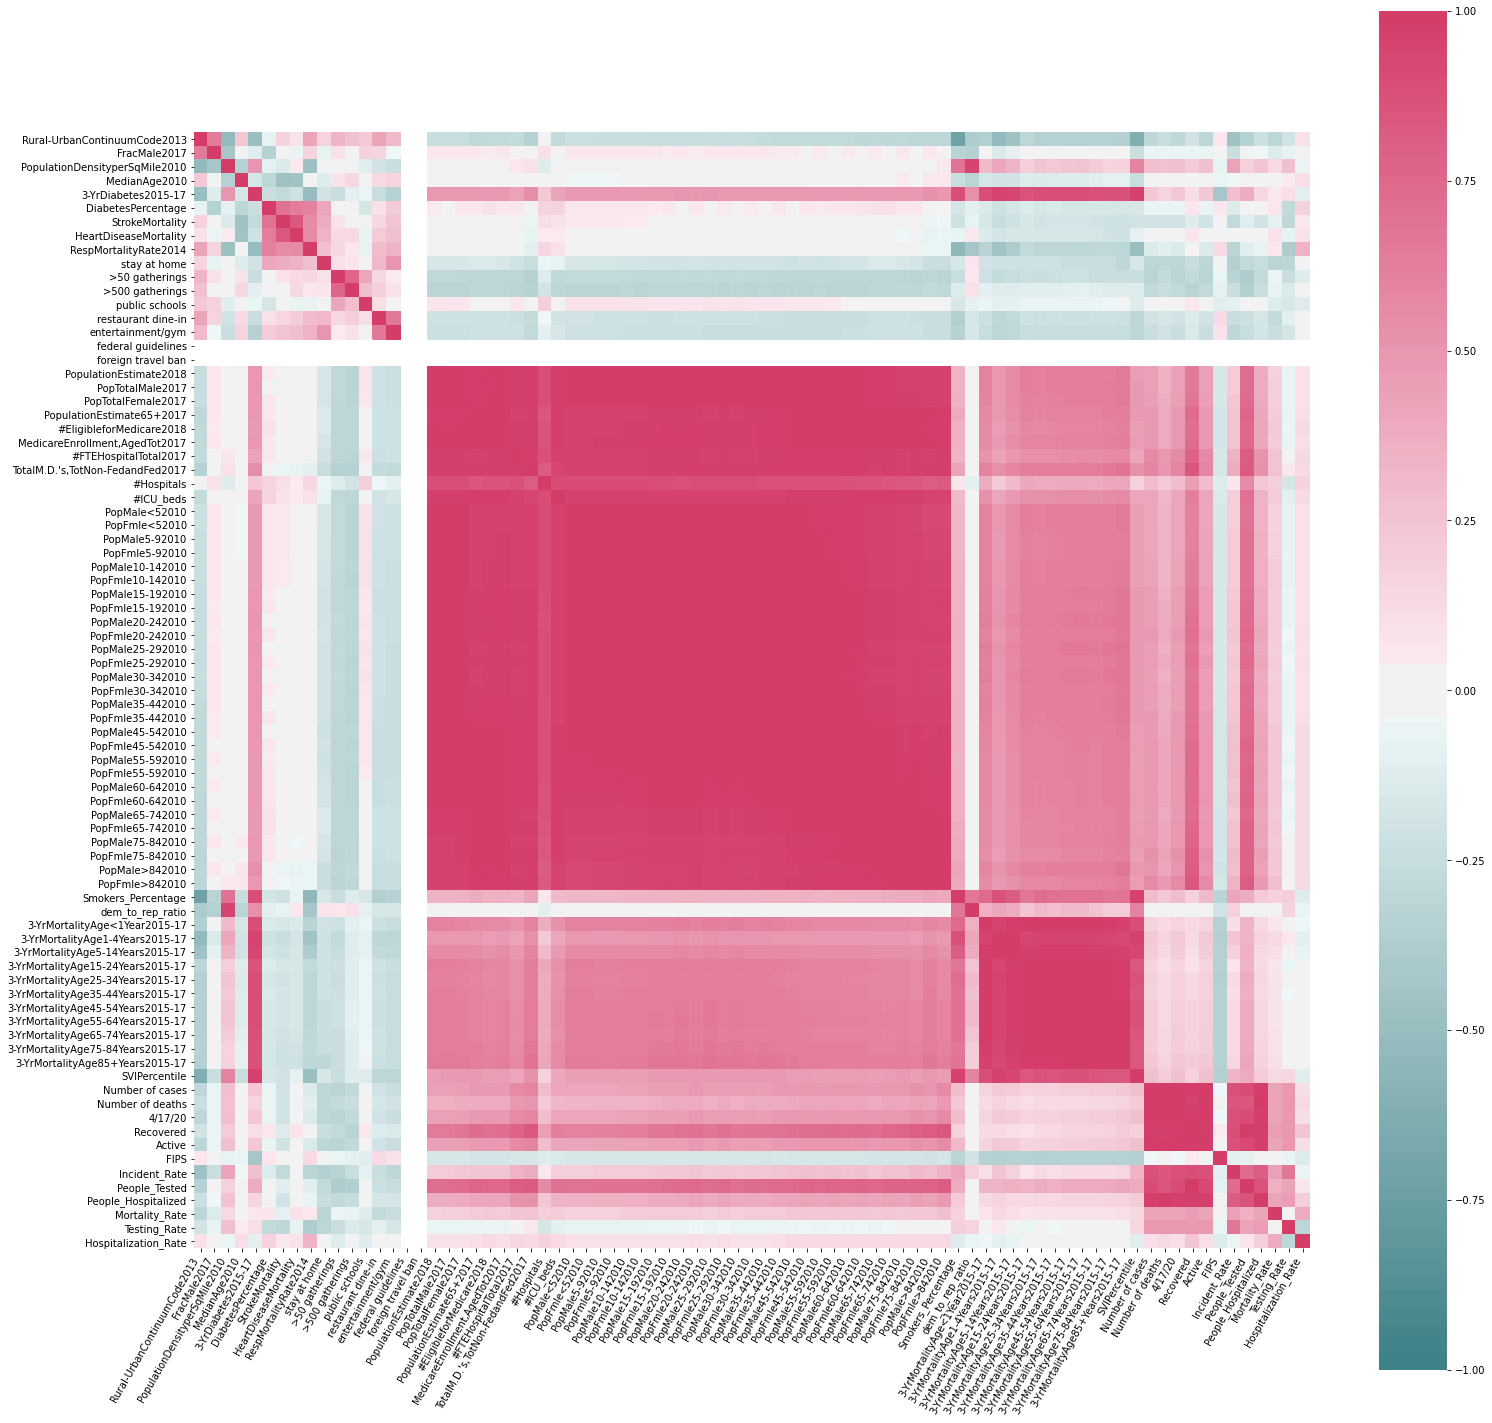

In [0]:
real_corr = abridged_by_state_with_cases.corr()
plt.subplots(figsize=(25,25))
ax = sns.heatmap(
    real_corr,
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap = sns.diverging_palette(200, 0, n=200),
    square = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=60,
    horizontalalignment='right'
)
plt.show()

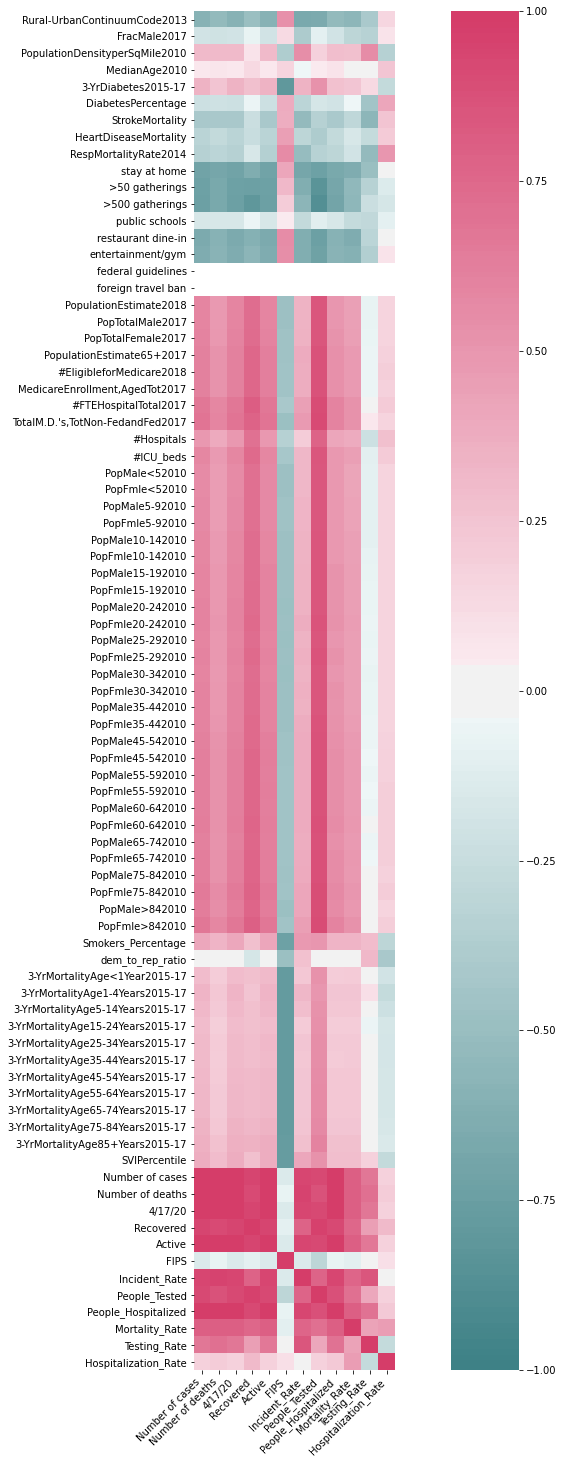

In [0]:
corr_last_two = real_corr.corr().iloc[:, 69:]
plt.subplots(figsize=(20,25))
ax = sns.heatmap(
    corr_last_two,
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap = sns.diverging_palette(200, 0, n=200),
    square = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

Now we separate the feature columns from the variables to predict (number of cases and number of deaths) as well as other parameters that may directly indicate the variables we attempt to predict with our models.

In [0]:
feature_cols = abridged_by_state_with_cases_na.drop(['Number of cases', 'Number of deaths', 'Recovered', 'Active', 'Mortality_Rate', 'Incident_Rate', 'StateName', 'Number of cases'], axis=1).dropna()
y = abridged_by_state_with_cases_na[['Number of cases']]
print("Number of initial features:", feature_cols.columns.size)
feature_cols.head()

Number of initial features: 75


,Rural-UrbanContinuumCode2013,FracMale2017,PopulationDensityperSqMile2010,MedianAge2010,3-YrDiabetes2015-17,DiabetesPercentage,StrokeMortality,HeartDiseaseMortality,RespMortalityRate2014,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,PopulationEstimate65+2017,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#Hospitals,#ICU_beds,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,PopFmle10-142010,PopMale15-192010,PopFmle15-192010,PopMale20-242010,PopFmle20-242010,PopMale25-292010,PopFmle25-292010,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,Smokers_Percentage,dem_to_rep_ratio,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,SVIPercentile,4/17/20,FIPS,People_Tested,People_Hospitalized,Testing_Rate,Hospitalization_Rate
0,7.337811,0.536606,33.660163,37.032131,48.064333,8.894451,38.377161,167.179478,57.447205,737511.857607,737507.733936,737507.54901,737502.941257,737501.250874,737501.355471,737500.0,737495.0,1.045433e+06,5.378221e+05,5.087504e+05,1.305886e+05,2.190189e+05,1.254013e+05,20441.708747,3149.095533,26.373448,189.954155,37618.973953,35410.136744,35833.568372,34237.052093,36133.84,34200.213953,37845.484651,35095.026047,40087.564651,34681.425116,39323.074419,35977.365581,34283.296744,32247.215814,67629.68093,64053.949767,78519.810233,74877.595349,35358.337674,33134.03907,26847.077209,24956.687442,27910.447442,27949.309767,11934.843721,15257.094884,3347.394419,6534.31907,5.686360e+05,3.300928e+04,1.103401e+06,6.443485e+05,7.104817e+05,1.138471e+06,1.652185e+06,1.746187e+06,2.959201e+06,5.464446e+06,6.070387e+06,6.340824e+06,7.140724e+06,15381.081466,309.0,2.0,9655.0,39.0,1615.226458,12.420382
2,5.640000,0.494874,54.357333,40.316000,44.349520,13.432000,47.681333,235.172000,72.727067,737512.481146,737510.000000,737510.00000,737501.000000,737503.000000,737503.000000,737500.0,737495.0,3.013825e+06,1.476064e+06,1.528215e+06,4.991440e+05,6.703520e+05,4.809900e+05,58025.000000,7753.000000,74.000000,732.000000,100950.000000,96739.000000,100871.000000,96006.000000,100896.00,96663.000000,104178.000000,99627.000000,100801.000000,98849.000000,96155.000000,95998.000000,92277.000000,91462.000000,182698.00000,183510.000000,200528.000000,206738.000000,88935.000000,95025.00000,80356.000000,86675.000000,110138.000000,124464.000000,56320.000000,77657.000000,16534.000000,34868.00000,7.840902e+05,2.584669e+04,1.250992e+06,7.925587e+05,8.739035e+05,1.335316e+06,1.684733e+06,2.193823e+06,3.539317e+06,6.972694e+06,9.744968e+06,1.125651e+07,1.282538e+07,26193.940319,1695.0,5.0,24141.0,291.0,932.435235,16.685780
4,3.800000,0.503349,52.046667,38.653333,140.078711,10.060000,30.900000,148.826667,51.968667,737515.000000,737501.000000,737501.00000,737500.000000,737503.000000,737503.000000,737500.0,737495.0,7.171646e+06,3.488301e+06,3.527969e+06,1.201746e+06,1.346727e+06,1.072318e+06,98442.000000,20222.000000,76.000000,1559.000000,232562.000000,223153.000000,231246.000000,222434.000000,228995.00,219669.000000,237280.000000,224302.000000,229562.000000,213022.000000,225608.000000,214390.000000,212223.000000,204472.000000,416123.00000,406371.000000,414910.000000,427636.000000,178665.000000,196603.00000,166954.000000,184006.000000,236227.000000,261665.000000,127730.000000,152809.000000,37738.000000,65

## Section C: PCA (more EDA)

Now we attempt to use PCA to reduce the dimensionality of our dataset. We first apply a standard scaling of the data to standardize it and then apply PCA using the SKLearn.decomposition package (PCA is a form of Singular Value Decomposition). We start with 75 features (from above) and bring it down to 8 principal components in order to explain 95% of the variance in our data. We then aimed to base a model off the 3 principal components with the highest weighting or singular values (the rest have a steep drop off). We plot a heatmap of the contribution of each of our original features to the 8 principal components and select the 30 columns that have the greatest contribution to the 3 most influential principal components. 

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(feature_cols)
x = scaler.transform(feature_cols)
pca = PCA(.95)
pca.fit(x)
x = pca.transform(x)
#print(pca.explained_variance_)
print("COMPONENTS SHAPE: ", pca.components_.shape)
comp1 = pca.components_[0]
comp1 =  [abs(ele) for ele in comp1] 
feat_list = []
store_dict = {}
for i in range(len(comp1)):
    store_dict[comp1[i]] = i
comp1.sort()
for i in range(10):
    feat_list.append(store_dict[comp1[-10:][i]])
comp3 = pca.components_[2]
comp3 = [abs(ele) for ele in comp3]
store_dict = {}
for i in range(len(comp3)):
    store_dict[comp3[i]] = i
comp3.sort()
for i in range(10):
    feat_list.append(store_dict[comp3[-10:][i]])
comp2 = pca.components_[1]
comp2 = [abs(ele) for ele in comp2]
store_dict = {}
for i in range(len(comp2)):
    store_dict[comp2[i]] = i
comp2.sort()
for i in range(10):
    feat_list.append(store_dict[comp2[-10:][i]])

feature_list = []
for i in feat_list:
  feature_list.append(feature_cols.columns[i])
print("PCA Features Size:", len(feature_list))
print("PCA Features:", feature_list)

COMPONENTS SHAPE:  (9, 75)
PCA Features Size: 30
PCA Features: ['PopMale60-642010', 'PopFmle55-592010', 'PopMale20-242010', 'PopFmle45-542010', 'PopMale65-742010', 'PopFmle65-742010', 'PopFmle60-642010', 'PopFmle20-242010', 'MedicareEnrollment,AgedTot2017', 'PopulationEstimate65+2017', 'restaurant dine-in', 'People_Tested', 'RespMortalityRate2014', '4/17/20', 'People_Hospitalized', 'stay at home', 'HeartDiseaseMortality', 'DiabetesPercentage', 'StrokeMortality', 'Testing_Rate', '3-YrMortalityAge65-74Years2015-17', '3-YrMortalityAge35-44Years2015-17', '3-YrMortalityAge25-34Years2015-17', 'SVIPercentile', '3-YrMortalityAge45-54Years2015-17', '3-YrMortalityAge55-64Years2015-17', '3-YrMortalityAge<1Year2015-17', '3-YrDiabetes2015-17', '3-YrMortalityAge5-14Years2015-17', '3-YrMortalityAge1-4Years2015-17']


Here, we plot a heatmap of how much each original feature influences each of the 9 total principal components. Bright yellow colors indicate a large positive influence on the principal component, bright blue indicates a large negative influence, gray indicates little influence. Since principal components are simply just linear combinations of the different features, we hypothesized that the features with the greatest influence in the primary principal components explain most of the variance in the data and would be the best to form our regression model with.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


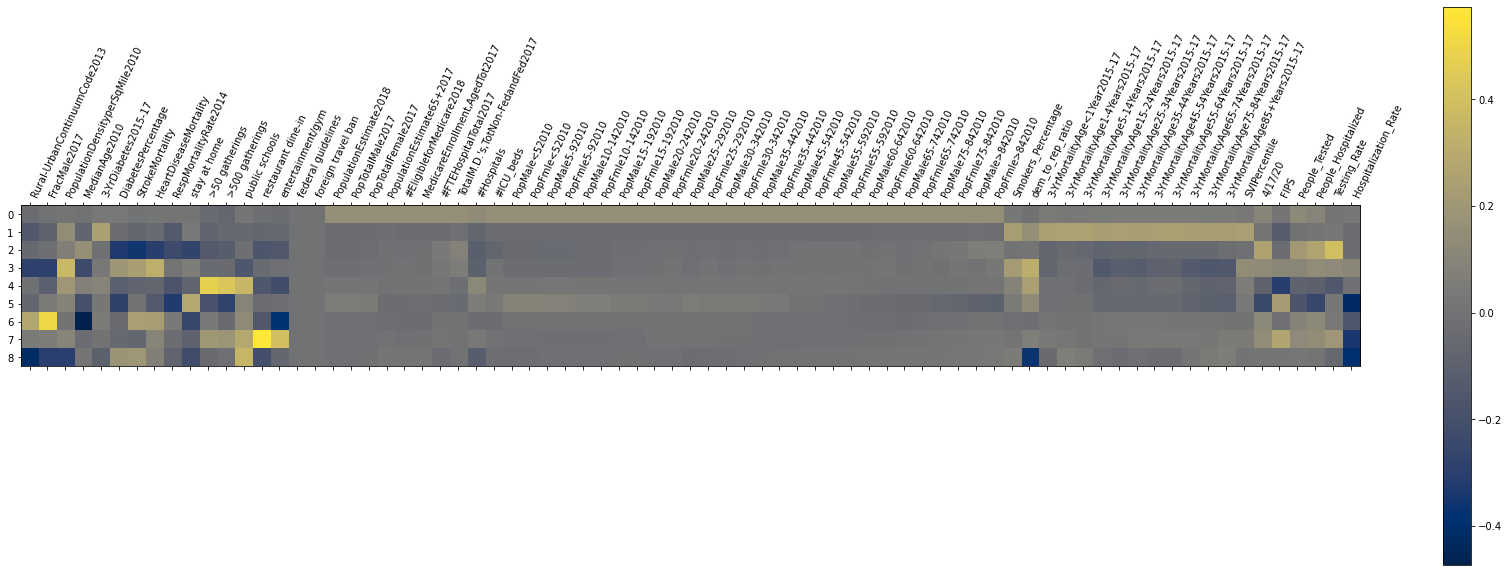

In [0]:
plt.figure(figsize=(30,10))
plt.matshow(pca.components_,cmap='cividis', fignum=1)
plt.yticks([0,1,2,3,4,5,6,7,8])
plt.colorbar()
plt.xticks(range(len(feature_cols.columns)),feature_cols.columns,rotation=65,ha='left')
plt.tight_layout()
plt.show()

# Part II: Feature Selection and Model Creation
## Section A: PCA Features Model (Model #1)

For our first stab at a model, we used the 30 features that contributed most to the 3 most influential principal components to predict the number of deaths for each state on 4/18/20 (the most recent total death count). We used a standard scaler to standardize the features and fit them using a Linear Regression Model. Utilized cross-validation and used a mean L1 loss to assess the model.

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def pca_calculate_error(model, X, Y):
  prediction = model.predict(X)
  error = 0
  for i in range(len(prediction)):
    error += abs(prediction[i] - Y[i])
  return error/len(Y)

feature_arr = abridged_by_state_with_cases_na[feature_list].to_numpy()
normalized_feature_arr = StandardScaler().fit_transform(feature_arr)
feat_model = LinearRegression()
cross_error = np.mean(cross_val_score(feat_model, normalized_feature_arr, abridged_by_state_with_cases_na['Number of deaths'].to_numpy(), scoring=pca_calculate_error, cv=5))
print("PCA Features:", feature_list)
print("PCA Features Cross Validation Error:", cross_error)

PCA Features: ['PopMale60-642010', 'PopFmle55-592010', 'PopMale20-242010', 'PopFmle45-542010', 'PopMale65-742010', 'PopFmle65-742010', 'PopFmle60-642010', 'PopFmle20-242010', 'MedicareEnrollment,AgedTot2017', 'PopulationEstimate65+2017', 'restaurant dine-in', 'People_Tested', 'RespMortalityRate2014', '4/17/20', 'People_Hospitalized', 'stay at home', 'HeartDiseaseMortality', 'DiabetesPercentage', 'StrokeMortality', 'Testing_Rate', '3-YrMortalityAge65-74Years2015-17', '3-YrMortalityAge35-44Years2015-17', '3-YrMortalityAge25-34Years2015-17', 'SVIPercentile', '3-YrMortalityAge45-54Years2015-17', '3-YrMortalityAge55-64Years2015-17', '3-YrMortalityAge<1Year2015-17', '3-YrDiabetes2015-17', '3-YrMortalityAge5-14Years2015-17', '3-YrMortalityAge1-4Years2015-17']
PCA Features Cross Validation Error: 600.9538630464497


In [0]:
correlation_table = abridged_by_state_with_cases_na.corr()
correlation_table = correlation_table.fillna(0).abs()
def death_features(threshold):
  deaths_features_list = []
  for i, j in zip(correlation_table.columns, correlation_table['Number of deaths']):
    if (j >= threshold):
        deaths_features_list.append(i)
  return deaths_features_list

## Section B: Best Combination Model (Model #2)

Uses a list of features to choose from and the number of features to be chosen from the list to return the best combination of features for predicting the number of deaths or cases (depending on the predict_col parameter) in a state. Used a hard-coded implementation of running through each combination and outputting the single best combination of features. The best combination is the one that when used to train a linear model gives the least mean absolute error.

In [0]:
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

def calculate_error(model, X, Y):
  prediction = model.predict(X)
  error = 0
  for i in range(len(prediction)):
    error += abs(prediction[i] - Y[i])
  return error/len(Y)

def output_features(feats_list, predict_col, num_feats):
  features_list = list(feats_list)
  features_list.remove('Number of deaths')
  features_list.remove('Number of cases')
  if(predict_col == 'Number of cases'):
    features_list.remove('Incident_Rate')
    features_list.remove('Recovered')
    features_list.remove('Active')
  feature_combinations = combinations(features_list, num_feats)
  min_error = float('inf')
  best_features = []
  best_features_arr = []
  for combination in list(feature_combinations):
    feature_frame = abridged_by_state_with_cases_na[list(combination)]
    feature_frame = pd.concat([feature_frame, abridged_by_state_with_cases_na[predict_col].to_frame()], axis=1)
    iter_correlation_table = feature_frame.corr()
    iter_correlation_table = iter_correlation_table.fillna(0)
    for i, j in zip(iter_correlation_table.columns, iter_correlation_table[predict_col]):
      if (j < 0):
        for ind in range(len(feature_frame[i])):
          feature_frame.loc[ind, i] = feature_frame.loc[ind, i]*-1
    feature_frame_arr = feature_frame.drop([predict_col], axis=1).to_numpy()
    normalized_features = StandardScaler().fit_transform(feature_frame_arr)
    model = LinearRegression()
    error = np.mean(cross_val_score(model, normalized_features, abridged_by_state_with_cases_na[predict_col].to_numpy(), scoring=calculate_error, cv=5))
    if (error < min_error):
      best_features = combination
      best_features_arr = normalized_features
      min_error = error
  return best_features, min_error, best_features_arr

deaths_features_list = death_features(0.6)
feats, err, feats_arr = output_features(deaths_features_list, 'Number of deaths', 18)
print("Best Combination of Features:", feats)
print("Best Combo Deaths Cross-Validation Error:", err)

Best Combination of Features: ('PopulationEstimate65+2017', 'MedicareEnrollment,AgedTot2017', '#FTEHospitalTotal2017', 'PopFmle45-542010', 'PopFmle55-592010', 'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010', 'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010', 'PopMale>842010', 'PopFmle>842010', '4/17/20', 'Active', 'Incident_Rate', 'People_Tested', 'People_Hospitalized')
Best Combo Deaths Cross-Validation Error: 81.30457012486221


Line graph of the mean absolute error (mean L1 loss) vs the number of features for linear models that predict the number of deaths in a given state.

Text(0, 0.5, 'Mean Absolute Error')

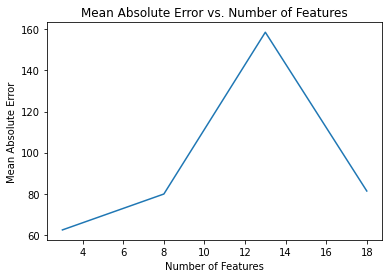

In [0]:
num_feat_lst = [i for i in range(3, 19, 5)]
errs = []
for num in num_feat_lst:
  e = 0
  if (num == 3 or num == 18):
    x_cols, e, x = output_features(death_features(0.6), 'Number of deaths', num)
  elif (num == 8):
    x_cols, e, x = output_features(death_features(0.7), 'Number of deaths', num)
  else:
    x_cols, e, x = output_features(death_features(0.63), 'Number of deaths', num)
  errs.append(e)
plt.plot(num_feat_lst, errs)
plt.title("Mean Absolute Error vs. Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Mean Absolute Error")

## Best Combination to predict Cases count (Model #2B)
Using the same algorithm to determine best combination of features for predicting the total number of deaths up until 4/18, we determined the best combination of features for predicting the total number of cases up until 4/18. Once again, we fit a linear regression model and used mean cross-validation L1 error to give a preliminary assessment of the model.

In [0]:
cases_features_list = []
for i, j in zip(correlation_table.columns, correlation_table['Number of cases']):
  if (j >= 0.61):
      cases_features_list.append(i)
print("Initial Cases Features List:", cases_features_list)

Initial Cases Features List: ['PopulationEstimate65+2017', '#EligibleforMedicare2018', 'MedicareEnrollment,AgedTot2017', '#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", 'PopFmle20-242010', 'PopMale45-542010', 'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010', 'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010', 'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010', 'PopMale>842010', 'PopFmle>842010', 'Number of cases', 'Number of deaths', '4/17/20', 'Recovered', 'Active', 'Incident_Rate', 'People_Tested', 'People_Hospitalized']


In [0]:
case_feats, case_err, case_arr = output_features(cases_features_list, 'Number of cases', 18)
print("Best Combination Features:", case_feats)
print("Best Combo Cases Cross-Validation Error:", case_err)

Best Combination Features: ('PopulationEstimate65+2017', '#EligibleforMedicare2018', 'MedicareEnrollment,AgedTot2017', '#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", 'PopMale45-542010', 'PopFmle45-542010', 'PopFmle55-592010', 'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010', 'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010', 'PopMale>842010', 'PopFmle>842010', '4/17/20', 'People_Hospitalized')
Best Combo Cases Cross-Validation Error: 125.84791024999929


## Section C: Regularization Model- Lasso Regression (Model #3)
While switching from the PCA model to the best-combination model brought error down significantly, we believed there was still more scope to improve our model. We decided to use a Lasso (least absolute shrinkage and selection operator) feature selection method to try to select the best features from the dataset to prevent overfitting. To give our model much more data to train on, we used the counties dataset to train our model, instead of the states data. We determined that there simply wasn't enough data points to build a reliable model with states so we decided to switch our training data to the counties data.

In [0]:
cases_by_county = covid19confirmed[['Admin2','Province_State','4/17/20', '4/18/20']]
deaths_by_county = covid19deaths[['Admin2','Province_State','4/18/20']]

After getting the number of cases (for 4/17/20 and 4/18/20) and deaths by county (only 4/18/20), we merge the cases by county and deaths by county dataframe from the abridged counties dataframe made from one of the given datasets. After dropping some unecessary columns that either had mostly NaN values or were not very useful for predicting the number of cases, we also renamed 4/18/20_x to cases and 4/18/20_y to deaths for clarity.

In [0]:
counties_cases_deaths = pd.merge(left=abridged_counties, right=cases_by_county, left_on=['CountyName','State'], right_on=['Admin2','Province_State'], how='inner')
counties_cases_deaths = pd.merge(left=counties_cases_deaths, right=deaths_by_county, left_on=['CountyName','State'], right_on=['Admin2','Province_State'], how='inner')
county_names = pd.DataFrame(counties_cases_deaths)
counties_cases_deaths = counties_cases_deaths.drop(columns=['Admin2_x','Admin2_y','Province_State_x','Province_State_y','countyFIPS','STATEFP','COUNTYFP','lat','lon','POP_LATITUDE','POP_LONGITUDE','HPSAShortage','HPSAServedPop','HPSAUnderservedPop'])
counties_cases_deaths = counties_cases_deaths.rename(columns={'4/18/20_x':'Cases','4/18/20_y':'Deaths'})
counties_cases_deaths.head()

,CountyName,StateName,State,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,PopFmle10-142010,PopMale15-192010,PopFmle15-192010,PopMale20-242010,PopFmle20-242010,PopMale25-292010,PopFmle25-292010,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,4/17/20,Cases,Deaths
0,Autauga,AL,Alabama,South,East South Central,2.0,55601.0,27007.0,28497.0,0.486578,8392.0,91.8,54571.0,37.0,11439.0,8046.0,16.0,9.9,204.5,56.1,18.081557,81.79,324.0,50.0,0.0,1.0,6.0,0.326656,1866.0,1713.0,2001.0,1990.0,2171.0,2119.0,2213.0,2077.0,1539.0,1541.0,1543.0,1614.0,1594.0,1736.0,3978.0,4265.0,4040.0,4165.0,1524.0,1559.0,1279.0,1498.0,1821.0,2192.0,841.0,1141.0,159.0,392.0,NaN,NaN,NaN,NaN,10.0,20.0,44.0,73.0,112.0,143.0,109.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,26,25,2
1,Baldwin,AL,Alabama,South,East South Central,3.0,218022.0,103225.0,109403.0,0.485472,42413.0,114.7,182265.0,41.1,54145.0,41590.0,33.0,8.5,183.2,41.9,17.489033,54.28,2101.0,536.0,0.0,3.0,51.0,0.253255,5614.0,5544.0,5832.0,5767.0,6076.0,5850.0,5930.0,5670.0,4793.0,4656.0,5183.0,5064.0,5317.0,5392.0,11620.0,11933.0,13047.0,13874.0,5943.0,6580.0,5728.0,6284.0,8558.0,9245.0,4379.0,5153.0,1176.0,2057.0,13.0,NaN,NaN,23.0,30.0,52.0,125.0,262.0,434.0,546.0,597.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,103,109,2
2,Barbour,AL,Alabama,South,East South Central,6.0,24881.0,13335.0,11935.0,0.527701,4757.0,31.0,27457.0,39.0,6681.0,4706.0,NaN,15.7,220.4,49.0,21.999985,69.82,181.0,12.0,0.0,1.0,5.0,0.893106,847.0,855.0,826.0,816.0,820.0,779.0,919.0,812.0,1048.0,746.0,1212.0,798.0,1162.0,646.0,2115.0,1513.0,2164.0,1854.0,910.0,907.0,859.0,940.0,1067.0,1171.0,498.0,730.0,129.0,314.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,44.0,65.0,72.0,68.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,15,18,0
3,Bibb,AL,Alabama,South,East South Central,1.0,22400.0,12138.0,10530.0,0.535469,3632.0,36.8,22915.0,37.8,5128.0,3389.0,NaN,13.3,225.5,57.2,19.114200,84.49,145.0,16.0,0.0,1.0,0.0,0.278124,712.0,666.0,759.0,646.0,771.0,669.0,806.0,737.0,811.0,680.0,987.0,616.0,1013.0,633.0,1895.0,1487.0,1883.0,1503.0,734.0,667.0,684.0,650.0,803.0,920.0,370.0,534.0,73.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,37.0,62.0,56.0,45.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,24,26,0
4,Blount,AL,Alabama,South,East South Central,1.0,57840.0,28607.0,29406.0,0.493114,10351.0,88.9,57322.0,39.0,13175.0,9542.0,NaN,14.9,224.8,52.8,19.208672,87.05,103.0,18.0,1.0,1.0,6.0,0.094317,1805.0,1811.0,1936.0,1944.0,2113.0,1971.0,2139.0,1894.0,1577.0,1530.0,1735.0,1701.0,1730.0,1711.0,4022.0,3903.0,4068.0,4017.0,1810.0,1884.0,

After importing some necessary libraries from sklearn, we filter out the dataframe so that only quantitative columns are selected. Categorical columns like region names, state names, and county names should not have an affect in predicting the number of cases, because we want to see if quantitative features in each county like the population affects case counts, not predict high case counts simply because that county is in New York State.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(counties_cases_deaths.select_dtypes(include=numerics).columns)
counties_cases_deaths = counties_cases_deaths[numerical_vars]
counties_cases_deaths.head()

,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,PopFmle10-142010,PopMale15-192010,PopFmle15-192010,PopMale20-242010,PopFmle20-242010,PopMale25-292010,PopFmle25-292010,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,4/17/20,Cases,Deaths
0,2.0,55601.0,27007.0,28497.0,0.486578,8392.0,91.8,54571.0,37.0,11439.0,8046.0,16.0,9.9,204.5,56.1,18.081557,81.79,324.0,50.0,0.0,1.0,6.0,0.326656,1866.0,1713.0,2001.0,1990.0,2171.0,2119.0,2213.0,2077.0,1539.0,1541.0,1543.0,1614.0,1594.0,1736.0,3978.0,4265.0,4040.0,4165.0,1524.0,1559.0,1279.0,1498.0,1821.0,2192.0,841.0,1141.0,159.0,392.0,NaN,NaN,NaN,NaN,10.0,20.0,44.0,73.0,112.0,143.0,109.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,26,25,2
1,3.0,218022.0,103225.0,109403.0,0.485472,42413.0,114.7,182265.0,41.1,54145.0,41590.0,33.0,8.5,183.2,41.9,17.489033,54.28,2101.0,536.0,0.0,3.0,51.0,0.253255,5614.0,5544.0,5832.0,5767.0,6076.0,5850.0,5930.0,5670.0,4793.0,4656.0,5183.0,5064.0,5317.0,5392.0,11620.0,11933.0,13047.0,13874.0,5943.0,6580.0,5728.0,6284.0,8558.0,9245.0,4379.0,5153.0,1176.0,2057.0,13.0,NaN,NaN,23.0,30.0,52.0,125.0,262.0,434.0,546.0,597.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,103,109,2
2,6.0,24881.0,13335.0,11935.0,0.527701,4757.0,31.0,27457.0,39.0,6681.0,4706.0,NaN,15.7,220.4,49.0,21.999985,69.82,181.0,12.0,0.0,1.0,5.0,0.893106,847.0,855.0,826.0,816.0,820.0,779.0,919.0,812.0,1048.0,746.0,1212.0,798.0,1162.0,646.0,2115.0,1513.0,2164.0,1854.0,910.0,907.0,859.0,940.0,1067.0,1171.0,498.0,730.0,129.0,314.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,44.0,65.0,72.0,68.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,15,18,0
3,1.0,22400.0,12138.0,10530.0,0.535469,3632.0,36.8,22915.0,37.8,5128.0,3389.0,NaN,13.3,225.5,57.2,19.114200,84.49,145.0,16.0,0.0,1.0,0.0,0.278124,712.0,666.0,759.0,646.0,771.0,669.0,806.0,737.0,811.0,680.0,987.0,616.0,1013.0,633.0,1895.0,1487.0,1883.0,1503.0,734.0,667.0,684.0,650.0,803.0,920.0,370.0,534.0,73.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,37.0,62.0,56.0,45.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,24,26,0
4,1.0,57840.0,28607.0,29406.0,0.493114,10351.0,88.9,57322.0,39.0,13175.0,9542.0,NaN,14.9,224.8,52.8,19.208672,87.05,103.0,18.0,1.0,1.0,6.0,0.094317,1805.0,1811.0,1936.0,1944.0,2113.0,1971.0,2139.0,1894.0,1577.0,1530.0,1735.0,1701.0,1730.0,1711.0,4022.0,3903.0,4068.0,4017.0,1810.0,1884.0,1700.0,1882.0,2391.0,2688.0,1102.0,1450.0,234.0,574.0,NaN,NaN,NaN,10.0,13.0,25.0,49.0,94.0,150.0,182.0,142.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4242,20,20,0


Now we have a table with only quantitative features as well as the cases/deaths for each county. We then split this dataframe into a training set with 70% of the data and a test set with 30% of the data to check our model. We drop Cases and Deaths from the X datasets as it wouldn't be very useful to predict the cases if we already know the deaths. The Y datasets are the cases because that is the value we want to predict.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    counties_cases_deaths.drop(labels=['Cases','Deaths'], axis=1),
    counties_cases_deaths['Cases'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((2116, 73), (908, 73))

Before using the data in our model, we need to scale the data to improve it for linear models. Having the data standardized makes sure that all the data in the features table looks like standardized normally distributed data to prevent the model from behaving badly. The columns with NaN values (the 3 year mortality columns) are filled with 0's because NaN simply means that nobody in that age group died in that county.

In [0]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

StandardScaler(copy=True, with_mean=True, with_std=True)

The select from model object is then initialized using a a penalty of "l1" which indicates that that it is using the Lasso method to select features. A low C value of 0.1 (chosen through further analysis below) makes sure that not too many features are selected for our model.

In [0]:
sel_ = SelectFromModel(LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

SelectFromModel(estimator=LogisticRegression(C=0.1, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l1',
                                             random_state=None,
                                             solver='liblinear', tol=0.0001,
                                             verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

This array marks True for the columns that are selected for our model from the feature table and marks False for the columns that have not been selected for our model.

In [0]:
sel_.get_support()

array([ True, False, False, False,  True, False,  True, False,  True,
       False, False, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True,  True,  True, False, False,  True, False, False, False,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True])

Out of the 73 features in our feature table, only 29 features were selected for our model.

In [0]:
selected_feat = X_train.columns[(sel_.get_support())]
print('total number of features with Lasso: {}'.format((X_train.shape[1])))
print('selected number of features with Lasso: {}'.format(len(selected_feat)))

total number of features with Lasso: 73
selected number of features with Lasso: 29


These were the features that were selected. Some features are interesting like Rural-UrbanContinuumCode2013 which suggests that rural counties and urban counties have different COVID-19 case growth. Other features such as FracMale2017 are unclear at first glance how they are helpful in the model, but were still chosen using lasso regularization.

In [0]:
print("Selected Features from Lasso Regression:", selected_feat)

Selected Features from Lasso Regression: Index(['Rural-UrbanContinuumCode2013', 'FracMale2017',
       'PopulationDensityperSqMile2010', 'MedianAge2010', 'DiabetesPercentage',
       'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage',
       'RespMortalityRate2014', '#FTEHospitalTotal2017',
       '#HospParticipatinginNetwork2017', '#Hospitals', 'dem_to_rep_ratio',
       'PopFmle15-192010', 'PopMale20-242010', '3-YrMortalityAge<1Year2015-17',
       '3-YrMortalityAge1-4Years2015-17', '3-YrMortalityAge15-24Years2015-17',
       '3-YrMortalityAge25-34Years2015-17',
       '3-YrMortalityAge35-44Years2015-17',
       '3-YrMortalityAge65-74Years2015-17', 'stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym', 'SVIPercentile', '4/17/20'],
      dtype='object')


We then transform the X_train and X_test set using our select from model object we initialized earlier. We then initialize a linear regression model and calculate the cross validation error as well as the test error for our model.

In [0]:
X_train_selected = sel_.transform(X_train.fillna(0))
X_test_selected = sel_.transform(X_test.fillna(0))
cases_lasso_model = LinearRegression()
print("Cases Cross Validation Error of Lasso Model:", np.mean(cross_val_score(cases_lasso_model, X_train_selected, y_train.to_numpy(), scoring=calculate_error, cv=5)))
cases_lasso_model.fit(X_train_selected, y_train.to_numpy())
print("Cases Test Error of Lasso Model:", calculate_error(cases_lasso_model, X_test_selected, y_test.to_numpy()))
cases_lasso_model.coef_

Cases Cross Validation Error of Lasso Model: 12.290265918324982
Cases Test Error of Lasso Model: 10.533533374899196


array([ 1.41338070e-01,  2.10991998e+01,  2.45794649e-02,  1.68580014e-01,
        1.62248434e-01, -8.99367013e-02,  3.24543003e-01,  6.23677701e-01,
        9.05073725e-02, -4.09414143e-04, -6.60724591e+00,  4.50218761e+00,
       -5.24323499e+00, -4.17291825e-03,  3.55771518e-03, -9.13236070e-01,
        1.41380385e+00,  1.04576222e+00, -4.87307923e-01,  1.77875269e-01,
       -2.68223452e-02, -3.23628621e-06, -1.75240326e-01,  1.75241431e-01,
        1.48791886e-01, -1.21624757e-01,  8.80942541e-07, -1.20034386e+00,
        1.04921409e+00])

To fine tune our model's accuracy, we change up different values of the regularization parameter from 0.1 to 1.0 to find the ideal value that minimizes the error. Smaller values of C indicate a stronger regularization parameter (less features chosen). The graph shows that the error is lowest when the parameter is at 0.1.

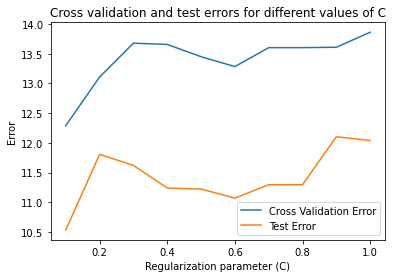

In [0]:
C_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
CV_errors = []
test_errors = []
for i in C_values:
  sel = SelectFromModel(LogisticRegression(C=i, penalty='l1', solver='liblinear', max_iter=1000))
  sel.fit(scaler.transform(X_train.fillna(0)), y_train)
  selected_feat = X_train.columns[(sel.get_support())]
  X_train_selected_test = sel.transform(X_train.fillna(0))
  X_test_selected_test = sel.transform(X_test.fillna(0))
  cases_lasso_model = LinearRegression()
  cverror = np.mean(cross_val_score(cases_lasso_model, X_train_selected_test, y_train.to_numpy(), scoring=calculate_error, cv=5))
  CV_errors.append(cverror)
  cases_lasso_model.fit(X_train_selected_test, y_train.to_numpy())
  testerror = calculate_error(cases_lasso_model, X_test_selected_test, y_test.to_numpy())
  test_errors.append(testerror)
plt.plot(C_values, CV_errors, label="Cross Validation Error")
plt.plot(C_values, test_errors, label="Test Error")
plt.legend()
plt.title("Cross validation and test errors for different values of C")
plt.xlabel("Regularization parameter (C)")
plt.ylabel("Error");

After the relative success of our model with features chosen using the lasso method, we decided to test if this exact same process can be used to predict deaths for each county. The steps are exactly the same as before.

In [0]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    counties_cases_deaths.drop(labels=['Cases','Deaths'], axis=1),
    counties_cases_deaths['Deaths'],
    test_size=0.3,
    random_state=0)
X_train1.shape, X_test1.shape

((2116, 73), (908, 73))

In [0]:
scaler1 = StandardScaler()
scaler1.fit(X_train1.fillna(0))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
sel_1 = SelectFromModel(LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))
sel_1.fit(scaler1.transform(X_train1.fillna(0)), y_train1)

SelectFromModel(estimator=LogisticRegression(C=0.1, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l1',
                                             random_state=None,
                                             solver='liblinear', tol=0.0001,
                                             verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [0]:
sel_1.get_support()

array([ True, False, False, False,  True, False, False, False,  True,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False,  True, False,  True, False,  True,  True, False,  True,
        True,  True, False,  True,  True,  True, False, False,  True,
        True])

In [0]:
selected_feat1 = X_train1.columns[(sel_1.get_support())]
print('total number of features: {}'.format((X_train1.shape[1])))
print('selected number of features: {}'.format(len(selected_feat1)))

total number of features: 73
selected number of features: 29


In [0]:
print("List of selected features:", selected_feat1)

List of selected features: Index(['Rural-UrbanContinuumCode2013', 'FracMale2017', 'MedianAge2010',
       'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality',
       'Smokers_Percentage', 'RespMortalityRate2014', '#FTEHospitalTotal2017',
       'TotalM.D.'s,TotNon-FedandFed2017', '#HospParticipatinginNetwork2017',
       '#ICU_beds', 'dem_to_rep_ratio', 'PopFmle15-192010', 'PopMale45-542010',
       '3-YrMortalityAge<1Year2015-17', '3-YrMortalityAge1-4Years2015-17',
       '3-YrMortalityAge25-34Years2015-17',
       '3-YrMortalityAge45-54Years2015-17',
       '3-YrMortalityAge65-74Years2015-17',
       '3-YrMortalityAge75-84Years2015-17', 'mortality2015-17Estimated',
       'stay at home', '>50 gatherings', 'public schools',
       'restaurant dine-in', 'entertainment/gym', 'SVIPercentile', '4/17/20'],
      dtype='object')


Our model for deaths was a relative success! The cross validation error is only 19.93 while the error for the test set on counties is only 14.67.

In [0]:
X_train_selected1 = sel_1.transform(X_train1.fillna(0))
X_test_selected1 = sel_1.transform(X_test1.fillna(0))
lasso_model = LinearRegression()
print("Deaths Cross Validation Error for 30 features:", np.mean(cross_val_score(lasso_model, X_train_selected1, y_train1.to_numpy(), scoring=calculate_error, cv=5)))
lasso_model.fit(X_train_selected1, y_train1.to_numpy())
print("Deaths Test Error for 30 features:", calculate_error(lasso_model, X_test_selected1, y_test1.to_numpy()))
lasso_model.coef_

Deaths Cross Validation Error for 30 features: 19.934297059439636
Deaths Test Error for 30 features: 14.666910532646458


array([ 2.26762099e-01,  4.72063820e+01, -1.95887286e-01,  8.09486450e-02,
       -1.41707627e-01,  5.73822902e-01,  6.62698297e-01,  2.35745519e-01,
       -2.12570284e-03,  1.73003162e-02, -4.96096574e+00,  6.07922245e-02,
        5.11657534e+00,  4.22846846e-03, -3.63071694e-03,  2.30361067e-01,
        7.77586921e+00, -1.65434942e+00,  6.95849205e-02,  5.19108073e-01,
       -3.13993983e-01, -7.16701547e-02, -7.44127705e-06,  7.69839753e-06,
        5.82757780e-02, -2.41883774e-01, -3.20826898e-06, -2.33335084e+01,
        9.65749505e-02])

Attempting to further the relative success of the lasso model, we try to predict the number of cases for each state using the abridged by state with cases table made earlier that contains the features for each state as well as that state's number of cases.

In [0]:
abridged_by_state_with_cases.head()

,StateName,Rural-UrbanContinuumCode2013,FracMale2017,PopulationDensityperSqMile2010,MedianAge2010,3-YrDiabetes2015-17,DiabetesPercentage,StrokeMortality,HeartDiseaseMortality,RespMortalityRate2014,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,PopulationEstimate65+2017,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#Hospitals,#ICU_beds,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,PopFmle10-142010,PopMale15-192010,PopFmle15-192010,PopMale20-242010,PopFmle20-242010,PopMale25-292010,PopFmle25-292010,...,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,Smokers_Percentage,dem_to_rep_ratio,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,SVIPercentile,Number of cases,Number of deaths,4/17/20,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,AK,7.337811,0.536606,33.660163,37.032131,48.064333,8.894451,38.377161,167.179478,57.447205,737511.857607,737507.733936,737507.549010,737502.941257,737501.250874,737501.355471,737500.0,737495.0,1.045433e+06,5.378221e+05,5.087504e+05,1.305886e+05,2.190189e+05,1.254013e+05,20441.708747,3149.095533,26.373448,189.954155,37618.973953,35410.136744,35833.568372,34237.052093,36133.840000,34200.213953,37845.484651,35095.026047,40087.564651,34681.425116,39323.074419,35977.365581,...,67629.68093,64053.949767,78519.810233,74877.595349,35358.337674,33134.03907,26847.077209,24956.687442,27910.447442,27949.309767,11934.843721,15257.094884,3347.394419,6534.319070,5.686360e+05,33009.283208,1.103401e+06,6.443485e+05,7.104817e+05,1.138471e+06,1.652185e+06,1.746187e+06,2.959201e+06,5.464446e+06,6.070387e+06,6.340824e+06,7.140724e+06,15381.081466,314.0,9.0,309.0,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,1615.226458,12.420382
1,AL,4.641791,0.486846,90.216418,39.356716,41.751095,14.407463,51.450746,243.595522,77.282985,737518.865672,737504.000000,737497.000000,737500.000000,737503.000000,737512.000000,737500.0,737495.0,4.887871e+06,2.359836e+06,2.514911e+06,8.037710e+05,1.080141e+06,7.818360e+05,88369.000000,12954.000000,86.000000,1533.000000,155265.000000,149692.000000,157340.000000,150889.000000,163417.000000,156238.000000,175151.000000,168320.000000,167520.000000,167802.000000,153716.000000,157318.000000,...,303785.00000,315716.000000,337828.000000,356026.000000,149633.000000,162273.00000,131603.000000,144524.000000,170036.000000,200465.000000,85611.000000,125996.000000,22859.000000,52825.000000,1.371885e+06,49111.821414,2.840754e+06,1.382547e+06,1.539827e+06,3.108637e+06,4.895118e+06,6.200122e+06,1.222209e+07,2.562700e+07,3.322148e+07,3.893587e+07,4.407658e+07,44905.444819,4712.0,153.0,4571.0,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,907.206961,13.157895
2,AR,5.640000,0.494874,54.357333,40.316000,44.349520,13.432000,47.681333,235.172000,72.727067,737512.481146,737510.000000,737510.000000,737501.000000,737503.000000,737503.000000,737500.0,737495.0,3.013825e+06,1.476064e+06,1.528215e+06,4.991440e+05,6.703520e+05,4.809900e+05,58025.000000,7753.000000,74.000000,732.000000,100950.000000,96739.000000,100871.000000,96006.000000,100896.000000,96663.000000,104178.000000,99627.000000,100801.000000,98849.000000,96155.000000,95998.000000,...,182698.00000,183510.000000,200528.000000,206738.000000,88935.000000,95025.0

To only select the state's features we filter out the non quantitative columns as well as "giveaway" columns like number of people recovered and active cases which may give a better estimate for the number of cases, but defeats the purpose of creating a model to predict cases.

In [0]:
select_state_features = abridged_by_state_with_cases.drop(columns=['Recovered','Active','Incident_Rate','People_Tested','People_Hospitalized','Mortality_Rate','Testing_Rate','Hospitalization_Rate'])
select_state_features = select_state_features.drop([27])
numerical_vars_states = list(select_state_features.select_dtypes(include=numerics).columns)
select_state_features = select_state_features[numerical_vars_states]
select_state_features.head()


,Rural-UrbanContinuumCode2013,FracMale2017,PopulationDensityperSqMile2010,MedianAge2010,3-YrDiabetes2015-17,DiabetesPercentage,StrokeMortality,HeartDiseaseMortality,RespMortalityRate2014,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,PopulationEstimate65+2017,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#Hospitals,#ICU_beds,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,PopFmle10-142010,PopMale15-192010,PopFmle15-192010,PopMale20-242010,PopFmle20-242010,PopMale25-292010,PopFmle25-292010,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,Smokers_Percentage,dem_to_rep_ratio,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,SVIPercentile,Number of cases,Number of deaths,4/17/20,FIPS
0,7.337811,0.536606,33.660163,37.032131,48.064333,8.894451,38.377161,167.179478,57.447205,737511.857607,737507.733936,737507.549010,737502.941257,737501.250874,737501.355471,737500.0,737495.0,1.045433e+06,5.378221e+05,5.087504e+05,1.305886e+05,2.190189e+05,1.254013e+05,20441.708747,3149.095533,26.373448,189.954155,37618.973953,35410.136744,35833.568372,34237.052093,36133.840000,34200.213953,37845.484651,35095.026047,40087.564651,34681.425116,39323.074419,35977.365581,34283.296744,32247.215814,67629.68093,64053.949767,78519.810233,74877.595349,35358.337674,33134.03907,26847.077209,24956.687442,27910.447442,27949.309767,11934.843721,15257.094884,3347.394419,6534.319070,5.686360e+05,33009.283208,1.103401e+06,6.443485e+05,7.104817e+05,1.138471e+06,1.652185e+06,1.746187e+06,2.959201e+06,5.464446e+06,6.070387e+06,6.340824e+06,7.140724e+06,15381.081466,314.0,9.0,309.0,2.0
1,4.641791,0.486846,90.216418,39.356716,41.751095,14.407463,51.450746,243.595522,77.282985,737518.865672,737504.000000,737497.000000,737500.000000,737503.000000,737512.000000,737500.0,737495.0,4.887871e+06,2.359836e+06,2.514911e+06,8.037710e+05,1.080141e+06,7.818360e+05,88369.000000,12954.000000,86.000000,1533.000000,155265.000000,149692.000000,157340.000000,150889.000000,163417.000000,156238.000000,175151.000000,168320.000000,167520.000000,167802.000000,153716.000000,157318.000000,146424.000000,151464.000000,303785.00000,315716.000000,337828.000000,356026.000000,149633.000000,162273.00000,131603.000000,144524.000000,170036.000000,200465.000000,85611.000000,125996.000000,22859.000000,52825.000000,1.371885e+06,49111.821414,2.840754e+06,1.382547e+06,1.539827e+06,3.108637e+06,4.895118e+06,6.200122e+06,1.222209e+07,2.562700e+07,3.322148e+07,3.893587e+07,4.407658e+07,44905.444819,4712.0,153.0,4571.0,1.0
2,5.640000,0.494874,54.357333,40.316000,44.349520,13.432000,47.681333,235.172000,72.727067,737512.481146,737510.000000,737510.000000,737501.000000,737503.000000,737503.000000,737500.0,737495.0,3.013825e+06,1.476064e+06,1.528215e+06,4.991440e+05,6.703520e+05,4.809900e+05,58025.000000,7753.000000,74.000000,732.000000,100950.000000,96739.000000,100871.000000,96006.000000,100896.000000,96663.000000,104178.000000,99627.000000,100801.000000,98849.000000,96155.000000,95998.000000,92277.000000,91462.000000,182698.00000,183510.000000,200528.000000,206738.000000,88935.000000,95025.00000,80356.000000,86675.000000,110138.000000,124464.000000,56320.000000,77657.000000,16534.000000,34868.000000,7.840902e+05,25846.686202,1.250992e+06,7.925587e+05,8.7

We then replicate the process done above on our new dataset for states.

In [0]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    select_state_features.drop(labels=['Number of cases','Number of deaths'], axis=1),
    select_state_features['Number of cases'],
    test_size=0.3,
    random_state=0)
X_train2.shape, X_test2.shape

((38, 71), (17, 71))

In [0]:
scaler2 = StandardScaler()
scaler2.fit(X_train2.fillna(0))

StandardScaler(copy=True, with_mean=True, with_std=True)

This time, our regularization parameter that we use is 1 because only 20 columns are selected out of 71, reducing it further will have too little features for our model to produce an accurate estimate.

In [0]:
sel_2 = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_2.fit(scaler2.transform(X_train2.fillna(0)), y_train2)

SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                             fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l1',
                                             random_state=None,
                                             solver='liblinear', tol=0.0001,
                                             verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [0]:
sel_2.get_support()

array([ True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False,  True, False, False,
       False, False, False,  True, False, False,  True,  True])

In [0]:
selected_feat2 = X_train2.columns[(sel_2.get_support())]
print('total features: {}'.format((X_train2.shape[1])))
print('selected features: {}'.format(len(selected_feat2)))

total features: 71
selected features: 20


In [0]:
print("20 selected features:", selected_feat2)

20 selected features: Index(['Rural-UrbanContinuumCode2013', 'FracMale2017', 'MedianAge2010',
       'DiabetesPercentage', 'StrokeMortality', 'HeartDiseaseMortality',
       'RespMortalityRate2014', 'stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym', '#Hospitals', 'Smokers_Percentage',
       'dem_to_rep_ratio', '3-YrMortalityAge15-24Years2015-17',
       '3-YrMortalityAge75-84Years2015-17', '4/17/20', 'FIPS'],
      dtype='object')


Although our model did relatively well on counties, it performed relatively poorly on states. We believe that it is due to the low number of states relative to counties (only 38 states to train our model on). Due to this low number, the model does not have enough information to produce an accurate estimate and make predictions for other states' data.

In [0]:
X_train_selected2 = sel_2.transform(X_train2.fillna(0))
X_test_selected2 = sel_2.transform(X_test2.fillna(0))
lasso_model = LinearRegression()
print("Cases Cross Validation Error 20 features (States):", np.mean(cross_val_score(lasso_model, X_train_selected2, y_train2.to_numpy(), scoring=calculate_error, cv=5)))
lasso_model.fit(X_train_selected2, y_train2.to_numpy())
print("Cases Test Error 20 features (States):", calculate_error(lasso_model, X_test_selected2, y_test2.to_numpy()))

Cases Cross Validation Error 20 features (States): 744.3790803517547
Cases Test Error 20 features (States): 298.30021617298615


# Part III: Visualizing our Model
Due to the success of using lasso to get features and then performing a linear regression on those selected features, we wanted to visualize the accuracy of our model. First, we selected 10 highly populated counties to do our first set of visualizations on.

In [0]:
counties_list = ['Los Angeles', 'Cook', 'Harris', 'Maricopa', 'Miami-Dade', 'New York', 'King', 'Clark', 'Wayne', 'Middlesex']
most_pop_counties = county_names.loc[county_names['CountyName'].isin(counties_list)]
most_pop_counties = most_pop_counties[most_pop_counties['PopulationEstimate2018'] > 1000000]
most_pop_counties = most_pop_counties.drop(columns=['Admin2_x','Admin2_y','Province_State_x','Province_State_y','countyFIPS','STATEFP','COUNTYFP','lat','lon','POP_LATITUDE','POP_LONGITUDE'])
most_pop_counties = most_pop_counties.rename(columns={'4/18/20_x':'Cases','4/18/20_y':'Deaths'})
most_pop_counties.head()

,CountyName,StateName,State,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,PopFmle10-142010,PopMale15-192010,PopFmle15-192010,PopMale20-242010,PopFmle20-242010,PopMale25-292010,PopFmle25-292010,...,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop,4/17/20,Cases,Deaths
72,Maricopa,AZ,Arizona,West,Mountain,1.0,4410824.0,2131219.0,2175814.0,0.494823,638316.0,414.9,3817117.0,34.6,706340.0,570367.0,1096.0,8.2,130.3,29.0,13.686398,51.21,59693.0,13059.0,14.0,34.0,1004.0,0.940519,144268.0,138502.0,144340.0,138369.0,141354.0,135874.0,142552.0,134347.0,137531.0,129341.0,139949.0,136755.0,...,261105.0,248168.0,255797.0,99040.0,109421.0,89536.0,100312.0,118994.0,136394.0,65158.0,83041.0,20884.0,38170.0,299.0,62.0,73.0,431.0,701.0,959.0,1960.0,3881.0,5655.0,7132.0,9265.0,1792.362620,737515.0,737501.0,737501.0,737500.0,737503.0,737503.0,737500.0,737495.0,0.6354,NaN,NaN,NaN,2404,2491,70
172,Los Angeles,CA,California,West,Pacific,1.0,10105518.0,5009834.0,5153673.0,0.492924,1343960.0,2419.6,9818605.0,34.8,1530126.0,1276832.0,2515.0,8.1,150.8,33.9,10.847678,34.94,157325.0,36517.0,22.0,76.0,2126.0,3.201541,330265.0,315528.0,323676.0,310014.0,347102.0,331743.0,385012.0,368618.0,385393.0,367395.0,386393.0,373209.0,...,716686.0,673001.0,695946.0,269289.0,291631.0,212254.0,239982.0,257486.0,310984.0,143180.0,202423.0,52700.0,98926.0,501.0,74.0,116.0,764.0,1264.0,1815.0,4129.0,8278.0,10827.0,14063.0,21296.0,3505.509038,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,737500.0,737495.0,0.7682,NaN,NaN,NaN,11400,12021,576
566,Cook,IL,Illinois,Midwest,East North Central,1.0,5180493.0,2530605.0,2680658.0,0.485603,743329.0,5495.1,5194675.0,35.3,845162.0,686929.0,1166.0,9.0,175.1,38.7,13.776183,41.02,111488.0,26136.0,24.0,46.0,1606.0,3.556127,174153.0,168340.0,168600.0,163237.0,172848.0,166728.0,183431.0,176759.0,184841.0,187662.0,214382.0,221128.0,...,358147.0,346934.0,370129.0,148009.0,164357.0,119841.0,137119.0,142918.0,181603.0,81211.0,123220.0,28136.0,63241.0,449.0,56.0,72.0,662.0,932.0,1203.0,2633.0,5722.0,7257.0,9049.0,12794.0,2474.644934,737505.0,737502.0,737502.0,737501.0,737502.0,737502.0,737500.0,737495.0,0.6755,NaN,NaN,NaN,19391,20395,860
1159,Middlesex,MA,Massachusetts,Northeast,New England,1.0,1614714.0,784054.0,818893.0,0.489133,240158.0,1837.9,1503085.0,38.5,280644.0,228657.0,275.0,6.8,121.8,24.5,9.954443,36.99,29577.0,10589.0,9.0,11.0,216.0,2.367500,43709.0,41962.0,44507.0,42986.0,46143.0,44303.0,50539.0,47834.0,51022.0,50724.0,56623.0,57123.0,...,108251.0,113909.0,119092.0,46535.0,50128.0,38600.0,42735.0,45325.0,54432.0,27351.0,39151.0,9600.0,21156.0,53.0,NaN,15.0,100.0,223.0,259.0,588.0,1151.0,1730.0,2717.0,4710.0,646.061967,737508.0,737501.0,7375

From this table of counties, we select the numeric columns. In the model we initialized above, we used the 4/17/20 column to predict the cases for 4/18/20. For the purpose of our visualizations however, we want to start at an earlier date such as 4/1/20, and plot our model's predictions all the way up to 4/18/20. Since the date changes for our model, we rename this column to Day Before to simply indicate the number of cases the day before we are trying to predict as when we try to predict the cases for 4/2/20, we won't be using 4/17/20 but rather the case count a day before.

In [0]:
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(most_pop_counties.select_dtypes(include=numerics).columns)
most_pop_counties_feature_selection = pd.DataFrame(most_pop_counties[numerical_vars])
most_pop_counties_feature_selection = most_pop_counties_feature_selection.rename(columns={'4/17/20': 'Day Before'})
most_pop_counties_feature_selection.head()

,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,PopFmle10-142010,PopMale15-192010,PopFmle15-192010,PopMale20-242010,PopFmle20-242010,PopMale25-292010,PopFmle25-292010,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop,Day Before,Cases,Deaths
72,1.0,4410824.0,2131219.0,2175814.0,0.494823,638316.0,414.9,3817117.0,34.6,706340.0,570367.0,1096.0,8.2,130.3,29.0,13.686398,51.21,59693.0,13059.0,14.0,34.0,1004.0,0.940519,144268.0,138502.0,144340.0,138369.0,141354.0,135874.0,142552.0,134347.0,137531.0,129341.0,139949.0,136755.0,133198.0,131224.0,263493.0,261105.0,248168.0,255797.0,99040.0,109421.0,89536.0,100312.0,118994.0,136394.0,65158.0,83041.0,20884.0,38170.0,299.0,62.0,73.0,431.0,701.0,959.0,1960.0,3881.0,5655.0,7132.0,9265.0,1792.362620,737515.0,737501.0,737501.0,737500.0,737503.0,737503.0,737500.0,737495.0,0.6354,NaN,NaN,NaN,2404,2491,70
172,1.0,10105518.0,5009834.0,5153673.0,0.492924,1343960.0,2419.6,9818605.0,34.8,1530126.0,1276832.0,2515.0,8.1,150.8,33.9,10.847678,34.94,157325.0,36517.0,22.0,76.0,2126.0,3.201541,330265.0,315528.0,323676.0,310014.0,347102.0,331743.0,385012.0,368618.0,385393.0,367395.0,386393.0,373209.0,360263.0,355866.0,713640.0,716686.0,673001.0,695946.0,269289.0,291631.0,212254.0,239982.0,257486.0,310984.0,143180.0,202423.0,52700.0,98926.0,501.0,74.0,116.0,764.0,1264.0,1815.0,4129.0,8278.0,10827.0,14063.0,21296.0,3505.509038,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,737500.0,737495.0,0.7682,NaN,NaN,NaN,11400,12021,576
566,1.0,5180493.0,2530605.0,2680658.0,0.485603,743329.0,5495.1,5194675.0,35.3,845162.0,686929.0,1166.0,9.0,175.1,38.7,13.776183,41.02,111488.0,26136.0,24.0,46.0,1606.0,3.556127,174153.0,168340.0,168600.0,163237.0,172848.0,166728.0,183431.0,176759.0,184841.0,187662.0,214382.0,221128.0,197362.0,198691.0,351648.0,358147.0,346934.0,370129.0,148009.0,164357.0,119841.0,137119.0,142918.0,181603.0,81211.0,123220.0,28136.0,63241.0,449.0,56.0,72.0,662.0,932.0,1203.0,2633.0,5722.0,7257.0,9049.0,12794.0,2474.644934,737505.0,737502.0,737502.0,737501.0,737502.0,737502.0,737500.0,737495.0,0.6755,NaN,NaN,NaN,19391,20395,860
1159,1.0,1614714.0,784054.0,818893.0,0.489133,240158.0,1837.9,1503085.0,38.5,280644.0,228657.0,275.0,6.8,121.8,24.5,9.954443,36.99,29577.0,10589.0,9.0,11.0,216.0,2.367500,43709.0,41962.0,44507.0,42986.0,46143.0,44303.0,50539.0,47834.0,51022.0,50724.0,56623.0,57123.0,52234.0,52344.0,104767.0,108251.0,113909.0,119092.0,46535.0,50128.0,38600.0,42735.0,45325.0,54432.0,27351.0,39151.0,9600.0,21156.0,53.0,NaN,15.0,100.0,223.0,259.0,588.0,1151.0,1730.0,2717.0,4710.0,646.061967,737508.0,737501.0,737501.0,737501.0,737501.0,737501.0,737500.0,737495.0,0.2264,NaN,NaN,NaN,7744,8297,294
1244,1

We then get our feature table and select the features that were selected when we ran lasso to find the best features for our model.

In [0]:
selected_feat = ['Rural-UrbanContinuumCode2013', 'FracMale2017',
       'PopulationDensityperSqMile2010', 'MedianAge2010', 'DiabetesPercentage',
       'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage',
       'RespMortalityRate2014', '#FTEHospitalTotal2017',
       '#HospParticipatinginNetwork2017', '#Hospitals', 'dem_to_rep_ratio',
       'PopFmle15-192010', 'PopMale20-242010', '3-YrMortalityAge<1Year2015-17',
       '3-YrMortalityAge1-4Years2015-17', '3-YrMortalityAge15-24Years2015-17',
       '3-YrMortalityAge25-34Years2015-17',
       '3-YrMortalityAge35-44Years2015-17',
       '3-YrMortalityAge65-74Years2015-17', 'stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym', 'SVIPercentile', 'Day Before']
most_pop_counties_selected = most_pop_counties_feature_selection[selected_feat]
most_pop_counties_selected = most_pop_counties_selected.fillna(0)
most_pop_counties_selected.head()

,Rural-UrbanContinuumCode2013,FracMale2017,PopulationDensityperSqMile2010,MedianAge2010,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,#HospParticipatinginNetwork2017,#Hospitals,dem_to_rep_ratio,PopFmle15-192010,PopMale20-242010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge65-74Years2015-17,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,SVIPercentile,Day Before
72,1.0,0.494823,414.9,34.6,8.2,130.3,29.0,13.686398,51.21,59693.0,14.0,34.0,0.940519,134347.0,137531.0,299.0,62.0,431.0,701.0,959.0,5655.0,737515.0,737501.0,737501.0,737500.0,737503.0,737503.0,0.6354,2404
172,1.0,0.492924,2419.6,34.8,8.1,150.8,33.9,10.847678,34.94,157325.0,22.0,76.0,3.201541,368618.0,385393.0,501.0,74.0,764.0,1264.0,1815.0,10827.0,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,0.7682,11400
566,1.0,0.485603,5495.1,35.3,9.0,175.1,38.7,13.776183,41.02,111488.0,24.0,46.0,3.556127,176759.0,184841.0,449.0,56.0,662.0,932.0,1203.0,7257.0,737505.0,737502.0,737502.0,737501.0,737502.0,737502.0,0.6755,19391
1159,1.0,0.489133,1837.9,38.5,6.8,121.8,24.5,9.954443,36.99,29577.0,9.0,11.0,2.367500,47834.0,51022.0,53.0,0.0,100.0,223.0,259.0,1730.0,737508.0,737501.0,737501.0,737501.0,737501.0,737501.0,0.2264,7744
1244,1.0,0.481361,2974.4,37.3,10.3,259.2,40.9,21.055530,53.48,38119.0,6.0,14.0,2.268384,71148.0,59269.0,217.0,28.0,261.0,489.0,661.0,3526.0,737508.0,737508.0,737508.0,737500.0,737500.0,737500.0,0.8723,13233


Training the model from the train dataset we made above, we then calculate the error in predicting the cases for the 10 counties we selected. It seems like a large error at 179.85, but to get a better judge of how our model fails, we will plot our model's predictions against the actual case numbers.

In [0]:
cases_lasso_model = LinearRegression()
cases_lasso_model.fit(X_train_selected, y_train.to_numpy())
print("Error:", calculate_error(cases_lasso_model, most_pop_counties_selected, most_pop_counties_feature_selection['Cases'].to_numpy()))

Error: 179.8485512976582


To make these visualizations, we first need to make a dataframe which stores the actual case counts for these 10 counties over 4/1/20 to 4/18/20. Getting the UIDs of these 10 counties to prevent duplicates, we make the case history table.

In [0]:
UIDs = [84004013, 84006037, 84012086, 84017031, 84025017, 84026163, 84032003, 84036061, 84048201, 84053033]
case_history = covid19confirmed.loc[covid19confirmed['UID'].isin(UIDs)]
case_history = case_history.rename(columns={'Admin2': 'CountyName'})
names_series = case_history['CountyName']
case_history = case_history.iloc[:, range(81, 99)]
case_history['CountyName'] = names_series 
prediction_table = pd.DataFrame(case_history['CountyName']).set_index('CountyName').sort_index()         
case_history = case_history.set_index('CountyName').sort_index()
case_history.head()

,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
CountyName,,,,,,,,,,,,,,,,,,
Clark,961,1125,1279,1418,1519,1608,1734,1878,2009,2144,2144,2324,2444,2509,2559,2559,2738,2882
Cook,5152,5575,6111,7439,8034,8728,9509,10520,11415,12472,13417,14585,15474,16323,17306,18087,19391,20395
Harris,847,955,1106,1284,1395,1809,2146,2341,3047,3261,3561,3629,3744,3907,4097,4306,4460,4653
King,2330,2656,2787,2898,3167,3331,3486,3688,3886,4117,4262,4426,4426,4549,4620,4697,4902,4902
Los Angeles,3518,4045,4566,4605,5955,6377,6936,7559,7955,8443,8453,8894,9433,10047,10517,10854,11400,12021


We then initialize a new table where we will be storing our model's predictions by county named prediction table. To get our predictions, we make a new table based on the feature table we made above and fill the prediction table column by column for each date from 4/1/20 to 4/18/20. It is necessary to change the "Day Before" column to the day before we are trying to predict, so we rename each date column to "Day Before" so that our model selects this as a feature. We also then have to reset old "Day Before" columns to "Old Data" in order for our model to not select the number of cases from dates older than the day before we are trying to predict.

In [0]:
prediction_table['4/1/20'] = case_history['4/1/20']

case_prediction = pd.DataFrame(most_pop_counties)
case_prediction = case_prediction.drop(columns=['StateName', 'State', 'CensusRegionName', 'CensusDivisionName','HPSAShortage','HPSAServedPop','HPSAUnderservedPop','4/17/20','Cases','Deaths'])
case_prediction = pd.merge(left=case_prediction, right=case_history, left_on='CountyName', right_on='CountyName', how='outer').set_index('CountyName').sort_index()
case_prediction = case_prediction.rename(columns={'4/1/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/2/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/2/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/3/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/3/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/4/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/4/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/5/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/5/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/6/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/6/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/7/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/7/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/8/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/8/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/9/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/9/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/10/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/10/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/11/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/11/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/12/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/12/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/13/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/13/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/14/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/14/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/15/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/15/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/16/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/16/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/17/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction = case_prediction.rename(columns={'Day Before': 'Old data'})
case_prediction = case_prediction.rename(columns={'4/17/20': 'Day Before'})
case_prediction_selected = case_prediction[selected_feat].fillna(0)
prediction_table['4/18/20'] = cases_lasso_model.predict(case_prediction_selected)
case_prediction.head()

,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,PopFmle10-142010,PopMale15-192010,PopFmle15-192010,PopMale20-242010,PopFmle20-242010,PopMale25-292010,PopFmle25-292010,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,...,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,Old data,Old data,Old data,Old data,Old data,Old data,Old data,Old data,Old data,Old data,Old data,Old data,Old data,Old data,Old data,Old data,Day Before,4/18/20
CountyName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Clark,1.0,2231647.0,1099565.0,1104514.0,0.498877,317010.0,247.3,1951269.0,35.5,369375.0,286927.0,330.0,10.0,204.3,36.7,16.979705,63.75,27320.0,4991.0,4.0,19.0,535.0,1.256736,70898.0,68084.0,69218.0,66193.0,68273.0,65387.0,67666.0,63774.0,65449.0,62796.0,75327.0,73367.0,74532.0,71299.0,148412.0,140074.0,134710.0,...,12509.0,149.0,35.0,44.0,209.0,378.0,569.0,1250.0,2392.0,3636.0,3989.0,3545.0,1043.465850,737516.0,737508.0,737508.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.7404,961,1125,1279,1418,1519,1608,1734,1878,2009,2144,2144,2324,2444,2509,2559,2559,2738,2882
Cook,1.0,5180493.0,2530605.0,2680658.0,0.485603,743329.0,5495.1,5194675.0,35.3,845162.0,686929.0,1166.0,9.0,175.1,38.7,13.776183,41.02,111488.0,26136.0,24.0,46.0,1606.0,3.556127,174153.0,168340.0,168600.0,163237.0,172848.0,166728.0,183431.0,176759.0,184841.0,187662.0,214382.0,221128.0,197362.0,198691.0,351648.0,358147.0,346934.0,...,63241.0,449.0,56.0,72.0,662.0,932.0,1203.0,2633.0,5722.0,7257.0,9049.0,12794.0,2474.644934,737505.0,737502.0,737502.0,737501.0,737502.0,737502.0,737500.0,737495.0,0.6755,5152,5575,6111,7439,8034,8728,9509,10520,11415,12472,13417,14585,15474,16323,17306,18087,19391,20395
Harris,1.0,4698619.0,2313530.0,2339450.0,0.497215,473982.0,2402.4,4092459.0,32.2,557568.0,436951.0,752.0,10.3,163.0,40.2,13.852122,39.89,92602.0,17134.0,19.0,34.0,918.0,1.296653,171219.0,165095.0,163674.0,156665.0,156729.0,149831.0,155268.0,145408.0,152317.0,145178.0,172849.0,167692.0,162188.0,158861.0,294916.0,293366.0,270763.0,...,24717.0,436.0,75.0,93.0,478.0,806.0,1074.0,2180.0,4320.0,5125.0,5361.0,6142.0,1556.940458,737508.0,737505.0,737498.0,737507.0,737503.0,737503.0,737500.0,737495.0,0.7236,847,955,1106,1284,1395,1809,2146,2341,3047,3261,3561,3629,3744,3907,4097,4306,4460,4653
King,1.0,2233163.0,1096784.0,1091865.0,0.501124,283909.0,912.9,1931249.0,37.1,333432.0,271948.0,386.0,7.1,118.9,29.6,8.815045,37.33,41960.0,12918.0,14.0,17.0,450.0,3.320354,61616.0,58678.0,57899.0,55396.0,56832.0,53957.0,60118.0,57396.0,65628.0,64194.0,81708.0,78948.0,77549.0,74512.0,151563.0,145227.0,146558.0,...,22602.0,92.0,15.0,17.0,138.0,246.0,352.0,793.0,1607.0,2200.0,2713.0,4873.0,733.478939,737507.0,737507.0,737495.0,737501.0,737501.0,737501.0,737500.0,737495.0,0.2854,2330,2656,2787,2898,3167,3331,3486,3688,3886,4117,4262,4426,4426,4549,4620,4697,4902,4902
Los Angeles,1.0,10105518.0,5009834.0,5153673.0,0.492924,1343960.0,24

We then have a prediction table identical to the case history table but filled with our model's predictions for each date instead of the actual case numbers.

In [0]:
prediction_table.head()

,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
CountyName,,,,,,,,,,,,,,,,,,
Clark,961,969.855055,1141.926165,1303.505135,1449.345893,1555.316515,1648.696569,1780.897544,1931.984373,2069.431418,2211.075320,2211.075320,2399.933855,2525.839546,2594.038462,2646.499166,2646.499166,2834.308487
Cook,5152,5366.627236,5810.444795,6372.823546,7766.179853,8390.462235,9118.616811,9938.053013,10998.808455,11937.855063,13046.874353,14038.381665,15263.863718,16196.615042,17087.397801,18118.775249,18938.211451,20306.386620
Harris,847,730.341214,843.656335,1002.087663,1188.847770,1305.310534,1739.685166,2093.270313,2297.867060,3038.612205,3263.144020,3577.908246,3649.254804,3769.914424,3940.936320,4140.286997,4359.572741,4521.151710
King,2330,2368.418679,2710.462472,2847.909517,2964.372281,3246.610870,3418.681980,3581.310164,3793.251409,4000.995798,4243.364253,4395.500295,4567.571405,4567.571405,4696.624738,4771.118938,4851.908423,5066.997311
Los Angeles,3518,3555.557093,4108.492917,4655.133456,4696.052806,6112.491823,6555.260168,7141.770842,7795.431218,8210.919997,8722.936471,8733.428612,9196.132024,9761.658417,10405.875867,10899.006488,11252.591635,11825.462526


To see what our model predicts for the number of cases over 4/1/20 to 4/18/20, we make a line plot of our predictions.

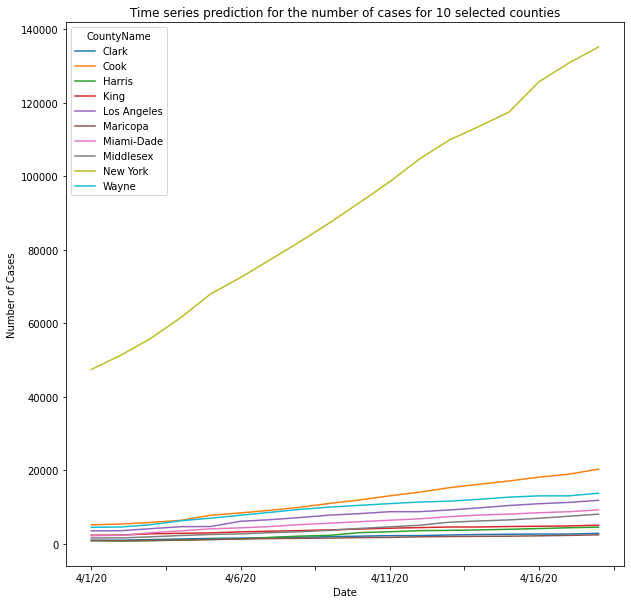

In [0]:
prediction_table_T = prediction_table.T
prediction_table_T.plot(figsize=(10,10))
plt.title("Time series prediction for the number of cases for 10 selected counties")
plt.xlabel("Date")
plt.ylabel("Number of Cases");

Due to New York County having significantly more cases than the other counties, we remove that and plot the 9 remaining counties for added clarity.

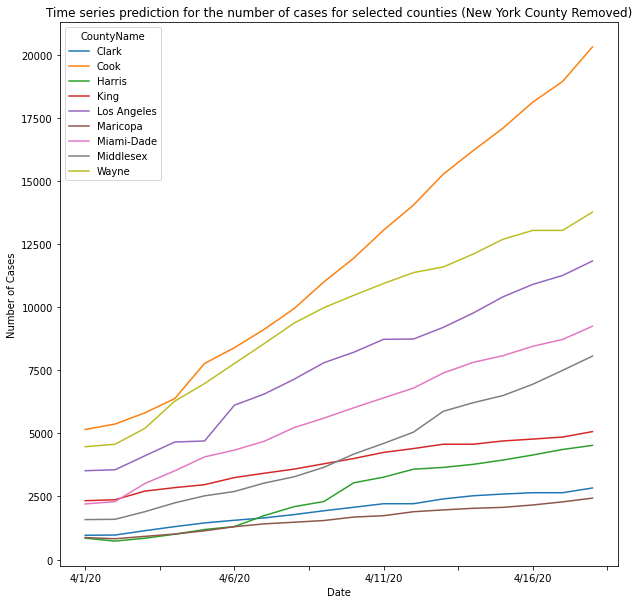

In [0]:
prediction_table_T_noNY = prediction_table_T.drop(columns=['New York'])
prediction_table_T_noNY.plot(figsize=(10,10))
plt.title("Time series prediction for the number of cases for selected counties (New York County Removed)")
plt.xlabel("Date")
plt.ylabel("Number of Cases");

We then plot the actual cases numbers from 4/1/20 to 4/18/20 for the ten counties we selected.

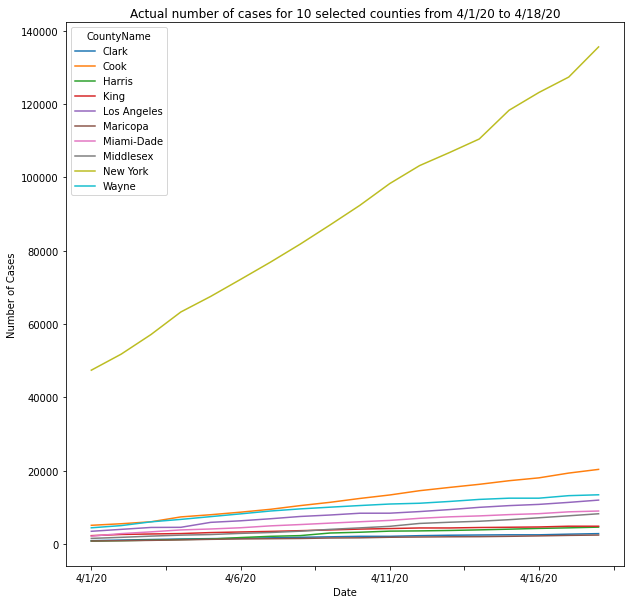

In [0]:
case_history_T = case_history.T
case_history_T.plot(figsize=(10,10))
plt.title("Actual number of cases for 10 selected counties from 4/1/20 to 4/18/20")
plt.xlabel("Date")
plt.ylabel("Number of Cases");

Again, we remove New York County for added clarity.

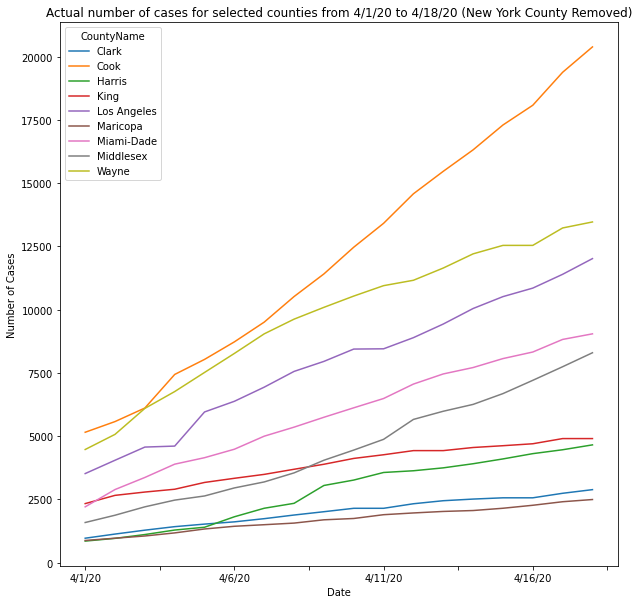

In [0]:
case_history_T_noNY = case_history_T.drop(columns=['New York'])
case_history_T_noNY.plot(figsize=(10,10))
plt.title("Actual number of cases for selected counties from 4/1/20 to 4/18/20 (New York County Removed)")
plt.xlabel("Date")
plt.ylabel("Number of Cases");

To get a better visualization of how our model does against the actual case numbers we combine the case history and prediction table into one dataframe, then plot this dataframe. We remove New York County and plot our predictions using dashed lines in the same color as the actual case numbers to increase clarity. As the graph indicates, our model does a relatively good job at modeling the growth of cases with our model's predictions closely following the growth of the actual COVID-19 cases for those counties.

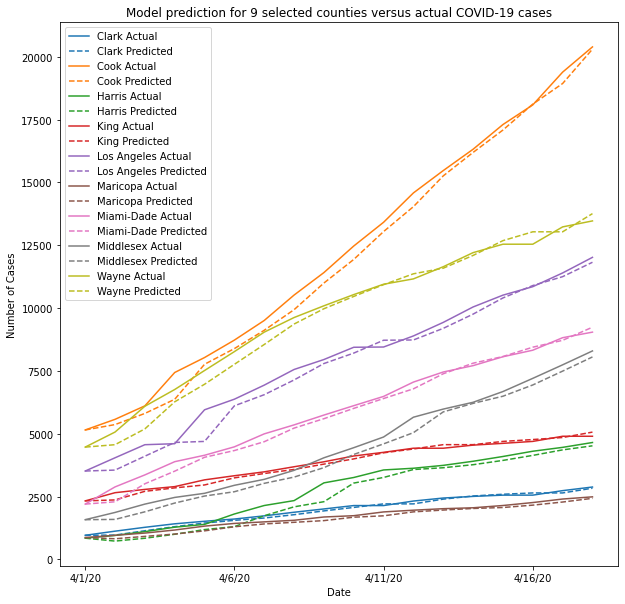

In [0]:
case_history_T_noNY_index_reset = case_history_T_noNY.reset_index()
prediction_table_T_noNY_index_reset = prediction_table_T_noNY.reset_index()
actual_and_predicted = pd.merge(left=case_history_T_noNY_index_reset, right=prediction_table_T_noNY_index_reset, left_on='index', right_on='index', how='outer')
actual_and_predicted = actual_and_predicted.rename(columns={'Clark_x': "Clark Actual", 'Cook_x': 'Cook Actual', 'Harris_x': 'Harris Actual', 'King_x': 'King Actual','Los Angeles_x': 'Los Angeles Actual', 'Maricopa_x': 'Maricopa Actual', 'Miami-Dade_x': 'Miami-Dade Actual', 'Middlesex_x': 'Middlesex Actual', 'Wayne_x': 'Wayne Actual', 'Clark_y': 'Clark Predicted', 'Cook_y': 'Cook Predicted', 'Harris_y': 'Harris Predicted', 'King_y': 'King Predicted', 'Los Angeles_y': 'Los Angeles Predicted', 'Maricopa_y':'Maricopa Predicted', 'Miami-Dade_y': 'Miami-Dade Predicted', 'Middlesex_y': 'Middlesex Predicted', 'Wayne_y':'Wayne Predicted'})
actual_and_predicted
plt.figure(figsize=(10,10));
plt.plot('index', 'Clark Actual', data=actual_and_predicted, marker='', color='C0', label='Clark Actual')
plt.plot('index', 'Clark Predicted', data=actual_and_predicted, marker='', color='C0', linestyle='dashed', label='Clark Predicted')
plt.plot('index', 'Cook Actual', data=actual_and_predicted, marker='', color='C1', label='Cook Actual')
plt.plot('index', 'Cook Predicted', data=actual_and_predicted, marker='', color='C1', linestyle='dashed', label='Cook Predicted')
plt.plot('index', 'Harris Actual', data=actual_and_predicted, marker='', color='C2', label='Harris Actual')
plt.plot('index', 'Harris Predicted', data=actual_and_predicted, marker='', color='C2', linestyle='dashed', label='Harris Predicted')
plt.plot('index', 'King Actual', data=actual_and_predicted, marker='', color='C3', label='King Actual')
plt.plot('index', 'King Predicted', data=actual_and_predicted, marker='', color='C3', linestyle='dashed', label='King Predicted')
plt.plot('index', 'Los Angeles Actual', data=actual_and_predicted, marker='', color='C4', label='Los Angeles Actual')
plt.plot('index', 'Los Angeles Predicted', data=actual_and_predicted, marker='', color='C4', linestyle='dashed', label='Los Angeles Predicted')
plt.plot('index', 'Maricopa Actual', data=actual_and_predicted, marker='', color='C5', label='Maricopa Actual')
plt.plot('index', 'Maricopa Predicted', data=actual_and_predicted, marker='', color='C5', linestyle='dashed', label='Maricopa Predicted')
plt.plot('index', 'Miami-Dade Actual', data=actual_and_predicted, marker='', color='C6', label='Miami-Dade Actual')
plt.plot('index', 'Miami-Dade Predicted', data=actual_and_predicted, marker='', color='C6', linestyle='dashed', label='Miami-Dade Predicted')
plt.plot('index', 'Middlesex Actual', data=actual_and_predicted, marker='', color='C7', label='Middlesex Actual')
plt.plot('index', 'Middlesex Predicted', data=actual_and_predicted, marker='', color='C7', linestyle='dashed', label='Middlesex Predicted')
plt.plot('index', 'Wayne Actual', data=actual_and_predicted, marker='', color='C8', label='Wayne Actual')
plt.plot('index', 'Wayne Predicted', data=actual_and_predicted, marker='', color='C8', linestyle='dashed', label='Wayne Predicted')
plt.xticks(ticks=['4/1/20', '4/6/20', '4/11/20', '4/16/20'])
plt.legend()
plt.title("Model prediction for 9 selected counties versus actual COVID-19 cases")
plt.xlabel("Date")
plt.ylabel("Number of Cases");

# Part IV: Intro to Possible Future Work

After building, testing, iterating, and finally visualizing our deaths predictor model, using just socio-economic and intrinsic features of the data, we thought of another angle to approach the problem: a mathematical model. By attempting to mathetmatically fit the pattern of deaths and cases and using other epidemic models such as SIR, we could increase the accuracy of our model greatly. Here, we provide an introduction as to how we may be able to expand upon our model in the future.

First we sort the deaths data by the total number of deaths (4/18/20 deaths) and take a few of the top 10 states to fit  a rudimentary exponential model for each.

In [0]:
sorted_deaths = deaths_group.sort_values(by='4/18/20', ascending=False)
sorted_deaths[0:10]

,Province_State,UID,code3,FIPS,Lat,Long_,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
36,New York,5378405916,53760,2405916.0,2637.737383,-4679.399365,23628065,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,2,10,13,17,38,46,60,117,158,210,285,385,527,883,1063,1342,1714,2176,2738,3262,3544,4029,4698,5489,6268,7067,7867,8627,9385,10058,10842,11617,14832,17131,17671
34,New Jersey,1932884509,19320,884509.0,846.015259,-1567.071444,8882190,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,2,2,3,5,9,11,16,20,27,44,62,81,108,140,161,198,267,355,537,646,846,917,1003,1232,1504,1709,1932,2183,2350,2443,2805,3156,3518,3840,4070
26,Michigan,7310474950,73080,2334941.0,3655.620467,-7070.080729,9986857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,3,9,15,24,43,61,92,111,132,184,259,335,417,479,540,617,727,845,959,1076,1276,1384,1479,1602,1768,1921,1996,2227,2308
25,Massachusetts,1428590248,14280,520246.0,630.994149,-1071.277031,6892503,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,5,9,11,15,25,35,44,48,56,89,122,154,192,216,231,260,356,433,503,599,686,756,844,844,1108,1108,1245,1404
22,Louisiana,5545582140,55440,1582140.0,1989.915353,-5876.747946,4648794,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,3,4,6,10,14,20,20,35,46,65,83,119,137,151,185,239,273,310,370,409,477,512,582,652,702,755,806,840,884,1013,1103,1156,1213,1267
17,Illinois,8737914438,87360,1914438.0,4064.049006,-9096.189667,12671821,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,4,5,6,9,12,16,19,26,34,47,66,73,99,141,163,210,244,274,307,380,462,528,597,677,720,798,868,949,1072,1132,1259
5,California,5040521376,50400,521376.0,2194.949775,-7002.258461,39512223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,4,4,4,3,5,7,12,16,18,24,25,30,39,50,65,81,94,110,124,146,173,199,238,265,289,348,380,432,495,544,583,604,640,714,767,860,956,1037,1140
7,Connecticut,840242082,8400,242082.0,332.909441,-581.254637,3565287,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3,4,4,8,10,12,19,21,27,33,34,36,69,85,112,131,165,189,206,277,326,380,448,494,554,602,671,868,971,1036,1086
43,Pennsylvania,5798988573,57960,2988573.0,2734.811250,-5200.226295,12801989,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,2,4,6,8,15,18,22,34,41,50,63,74,90,102,136,151,179,247,318,345,418,503,557,589,691,779,841,921,1042
11,Florida,5796978574,57960,978574.0,1939.030577,-5540.949842,21477737,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,3,3,5,7,9,11,13,13,18,18,23,29,35,54,56,63,85,87,164,170,195,221,236,283,309,354,390,438,461,499,571,596,668,725,748


We select California, New York, Washington, and Michigan to build our models. As we later plot, each of these 4 states has a completely different trajectory in terms of when the state's cases started to grow and to what extent it grew. 
Here, we display how many days (until 4/18) it has been since the state saw its 10th case. We also use the data after the 10th case to standardize our model, since we can easily pick an "initial value" for our exponential fit to be 10 and simply have to analyze the effects of the growth factor.

We see that California reached its 10th case quite early while Michigan is relatively new to the pandemic.

In [0]:
confirmed_group = covid19confirmed.groupby('Province_State').sum().reset_index()
confirmed_group = confirmed_group[(confirmed_group['Province_State']!='Diamond Princess') & (confirmed_group['Province_State']!='Grand Princess')]
cali_cases = confirmed_group[confirmed_group['Province_State']=='California']
cali_cases = cali_cases.iloc[:, 7:]
cali_cases = cali_cases.T[cali_cases.T[5] >= 10].T
cali_early = cali_cases.iloc[:, :21]
cali_days_since_10 = cali_cases.columns.size
ny_cases = confirmed_group[confirmed_group['Province_State']=='New York']
ny_cases = ny_cases.iloc[:, 7:]
ny_cases = ny_cases.T[ny_cases.T[36] >= 10].T
ny_early = ny_cases.iloc[:, :21]
ny_days_since_10 = ny_cases.columns.size
wa_cases = confirmed_group[confirmed_group['Province_State']=='Washington']
wa_cases = wa_cases.iloc[:, 7:]
wa_cases = wa_cases.T[wa_cases.T[54] >= 10].T
wa_early = wa_cases.iloc[:, :21]
wa_days_since_10 = wa_cases.columns.size
mi_cases = confirmed_group[confirmed_group['Province_State']=='Michigan']
mi_cases = mi_cases.iloc[:, 7:]
mi_cases = mi_cases.T[mi_cases.T[26] >= 10].T
mi_early = mi_cases.iloc[:, :21]
mi_days_since_10 = mi_cases.columns.size
print("Days since CA's 10th case:", cali_days_since_10)
print("Days since NY's 10th case:", ny_days_since_10)
print("Days since WA's 10th case:", wa_days_since_10)
print("Days since MI's 10th case:", mi_days_since_10)

Days since CA's 10th case: 58
Days since NY's 10th case: 46
Days since WA's 10th case: 49
Days since MI's 10th case: 37


Using an exponential model with the equation 
y(t) = 10*b^t, with the standardized initial value of y(0) = 10, t = timestep in days since the 10th case, we find the best fit b parameter (growth factor) using scipy.optimize's curve_fit module. We find the best fit on the number of deaths in the first 3 weeks since the 10th case as a timeframe to model the "early" growth of COVID-19 in each state. Here we see that California has a fairly low "early" growth factor which allowed it to contain the spread, whereas New York and Michigan had large early growth factors; Washington had a medium early growth factor.



In [0]:
from scipy.optimize import curve_fit

yo = cali_early.T
yo = yo.reset_index()
yo['timestep'] = yo.index.to_series()
def func3(x, b):
    return 10*b**x
popt, pcov = curve_fit(func3, yo['timestep'], yo[5])
cal_early_factor = popt[0]
print("Cal early growth factor:", cal_early_factor)
yo = ny_early.T
yo = yo.reset_index()
yo['timestep'] = yo.index.to_series()
popt, pcov = curve_fit(func3, yo['timestep'], yo[36])
ny_early_factor = popt[0]
print("NY early growth factor:", ny_early_factor)
yo = wa_early.T
yo = yo.reset_index()
yo['timestep'] = yo.index.to_series()
popt, pcov = curve_fit(func3, yo['timestep'], yo[54])
wa_early_factor = popt[0]
print("WA early growth factor:", wa_early_factor)
yo = mi_early.T
yo = yo.reset_index()
yo['timestep'] = yo.index.to_series()
popt, pcov = curve_fit(func3, yo['timestep'], yo[26])
mi_early_factor = popt[0]
print("MI early factor:", mi_early_factor)
early_factors = [cal_early_factor, ny_early_factor, wa_early_factor, mi_early_factor]

Cal early growth factor: 1.1584545214456672
NY early growth factor: 1.4898494707742036
WA early growth factor: 1.3057515904782204
MI early factor: 1.431908607213463


Using the same exponential fit equation, we now use all the data since the 10th case to model the overall growth rate, once again using a standard initial value of 10. 


Here, we see that all states were able to decrease their overall growth factors as time passed, indicating that the exponential model started to slow down. This indicates that a better model to use could be a logistic growth curve.


This slow-down in growth could be an outcome of the shelter-in place orders each state received. As we know, California was the first state to implement these orders, with the Bay Area counties being the first counties in the nation to do so. This could explain California's constant low growth factor both early and overall. As Bay Area residents ourselves, the authors are very proud of the Bay for this accomplishment, leading the nation in the battle to "flatten the curve".


Additionally, Washington's strict shelter-in-place orders allowed it to bring its overall growth factor down, compared to its relatively high early growth factor. As other states followed up with their shelter-in-place orders, their growth factors also started to slow down.

In [0]:
import statsmodels.api as sm
from scipy.optimize import curve_fit
yo = cali_cases.T
yo = yo.reset_index()
yo['timestep'] = yo.index.to_series()
def func3(x, b):
    return 10*b**x
popt, pcov = curve_fit(func3, yo['timestep'], yo[5])
cal_overall_factor = popt[0]
print("Cal overall growth factor:", cal_overall_factor)
yo = ny_cases.T
yo = yo.reset_index()
yo['timestep'] = yo.index.to_series()
popt, pcov = curve_fit(func3, yo['timestep'], yo[36])
ny_overall_factor = popt[0]
print("NY overall growth factor:", ny_overall_factor)
yo = wa_cases.T
yo = yo.reset_index()
yo['timestep'] = yo.index.to_series()
popt, pcov = curve_fit(func3, yo['timestep'], yo[54])
wa_overall_factor = popt[0]
print("WA overall growth factor:", wa_overall_factor)
yo = mi_cases.T
yo = yo.reset_index()
yo['timestep'] = yo.index.to_series()
popt, pcov = curve_fit(func3, yo['timestep'], yo[26])
mi_overall_factor = popt[0]
print("MI overall growth factor:", mi_overall_factor)
overall_factors = [cal_overall_factor, ny_overall_factor, wa_overall_factor, mi_overall_factor]

Cal overall growth factor: 1.157454050249718
NY overall growth factor: 1.2625072988577124
WA overall growth factor: 1.1689302286046441
MI overall growth factor: 1.264119924927659


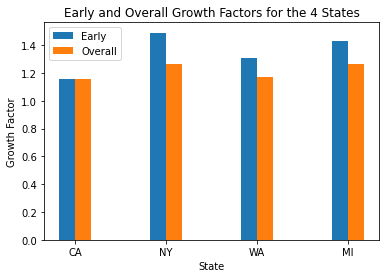

In [0]:
ca_factors = [cal_early_factor, cal_overall_factor]
ny_factors = [ny_early_factor, ny_overall_factor]
wa_factors = [wa_early_factor, wa_overall_factor]
mi_factors = [mi_early_factor, mi_overall_factor]
fig, ax = plt.subplots()
ind = np.arange(4) 
width = 0.35        
ax.bar(ind, early_factors, width/2, label='Early')
ax.bar(ind+width/2, overall_factors, width/2, label='Overall')

ax.set_title('Early and Overall Growth Factors for the 4 States')
ax.set_xticks(ind+width/4)
ax.set_xticklabels(('CA', 'NY', 'WA', 'MI'))
ax.set_xlabel('State')
ax.set_ylabel('Growth Factor')

ax.legend()
ax.autoscale_view()

plt.show()

Below, we plot the exponential curve fits over the total number of confirmed cases for each of the four states both early and overall.

In the "early" (first 3 weeks after 10th case) graph, we see that the exponential models fit relatively well, indicating that the spread of COVID-19 in each state was exponential at the beginning. However, in the overall graphs, we see that the exponential model does a relatively poor job of fitting the data, indicating that an exponential model may not be the best for modeling the overall growth of the pandemic. For future work, we may instead consider using a logistic curve to better fit the data, as the possible effects of the shelter-in-place orders are seen.

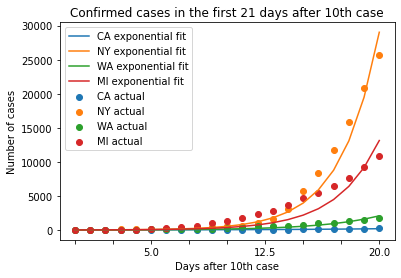

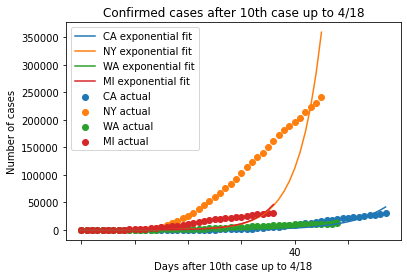

In [0]:
fig, ax = plt.subplots()
plt.scatter(range(cali_early.columns.size), cali_early.iloc[0], label = 'CA actual')
x_range = range(cali_early.columns.size)
plt.plot(x_range, 10*(cal_early_factor**x_range), label = 'CA exponential fit')

plt.scatter(range(ny_early.columns.size), ny_early.iloc[0], label = 'NY actual')
x_range = range(ny_early.columns.size)
plt.plot(x_range, 10*(ny_early_factor**x_range), label = 'NY exponential fit')

plt.scatter(range(wa_early.columns.size), wa_early.iloc[0], label = 'WA actual')
x_range = range(wa_early.columns.size)
plt.plot(x_range, 10*(wa_early_factor**x_range), label = 'WA exponential fit')

plt.scatter(range(mi_early.columns.size), mi_early.iloc[0], label = 'MI actual')
x_range = range(mi_early.columns.size)
plt.plot(x_range, 10*(mi_early_factor**x_range), label = 'MI exponential fit')
every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.title('Confirmed cases in the first 21 days after 10th case') 
plt.xlabel('Days after 10th case')
plt.ylabel('Number of cases')
plt.legend();

        
fig, ax = plt.subplots()
plt.scatter(range(cali_cases.columns.size), cali_cases.iloc[0], label = 'CA actual')
x_range = range(cali_cases.columns.size)
plt.plot(x_range, 10*(cal_overall_factor**x_range), label = 'CA exponential fit')

plt.scatter(range(ny_cases.columns.size), ny_cases.iloc[0], label = 'NY actual')
x_range = range(ny_cases.columns.size)
plt.plot(x_range, 10*(ny_overall_factor**x_range), label = 'NY exponential fit')

plt.scatter(range(wa_cases.columns.size), wa_cases.iloc[0], label = 'WA actual')
x_range = range(wa_cases.columns.size)
plt.plot(x_range, 10*(wa_overall_factor**x_range), label = 'WA exponential fit')

plt.scatter(range(mi_cases.columns.size), mi_cases.iloc[0], label = 'MI actual')
x_range = range(mi_cases.columns.size)
plt.plot(x_range, 10*(mi_overall_factor**x_range), label = 'MI exponential fit')
every_nth = 5
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.title('Confirmed cases after 10th case up to 4/18') 
plt.xlabel('Days after 10th case up to 4/18')
plt.ylabel('Number of cases')
plt.legend();

Using rough benchmarks established by cursory analysis of growth factors of California, Washington, Michigan, and New York, we attempt to classify each state into one of 3 growth groups: Low, Medium, or High danger.

We used the growth rates similar to that of California to indicate low danger, growth rates similar to that of Washington's early growth rate to indicate medium danger, and growth rates similar to that of New York's early growth rate to indicate high danger. 

 We then plot the distribution of the growth rates, along with a color to indicate the classification we gave each state.

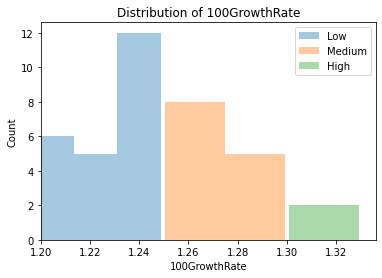

In [0]:
confirmed_group = covid19confirmed.groupby('Province_State').sum().reset_index()
confirmed_group = confirmed_group[(confirmed_group['Province_State']!='Diamond Princess') & (confirmed_group['Province_State']!='Grand Princess')]
danger_classification = []
growth_rate = []
for i in confirmed_group.index:
    curr_cases = confirmed_group.loc[i].to_frame().T
    curr_cases = curr_cases.fillna(0)
    if (curr_cases['4/18/20'].iloc[0] < 100):
        growth_rate.append(0)
        danger_classification.append('undetermined')
    else:
        curr_cases = curr_cases.iloc[:, 7:]
        curr_cases = curr_cases.T[curr_cases.T[i] >= 100].T
        curr_cases = curr_cases.T.reset_index()
        curr_cases['timestep'] = curr_cases.index.to_series()
        def func3(x, b):
            return 10*b**x
        popt, pcov = curve_fit(func3, curr_cases['timestep'], curr_cases[i])
        curr_early_factor = popt[0]
        growth_rate.append(curr_early_factor)
        if (curr_early_factor > 1.3):
            danger_classification.append("High")
        elif (curr_early_factor > 1.25):
            danger_classification.append("Medium")
        else:
            danger_classification.append("Low")
confirmed_group['Danger Classification'] = danger_classification
confirmed_group['100GrowthRate']  = growth_rate
#confirmed_group.head()
low_plot = sns.distplot(confirmed_group[confirmed_group['Danger Classification'] == 'Low']['100GrowthRate'],  kde=False, label='Low')
med_plot = sns.distplot(confirmed_group[confirmed_group['Danger Classification'] == 'Medium']['100GrowthRate'],  kde=False, label='Medium')
high_plot = sns.distplot(confirmed_group[confirmed_group['Danger Classification'] == 'High']['100GrowthRate'],  kde=False, label='High')
low_plot.set_xlim(1.2,)
med_plot.set_xlim(1.2,)
high_plot.set_xlim(1.2,)
plt.legend()
plt.title("Distribution of 100GrowthRate")
plt.ylabel("Count");